In [1]:
import pandas as pd
import numpy as np
import re # regex
import os

In [2]:
dict_all_teams = {'Milwaukee Bucks' : 'MIL', 'Houston Rockets' : 'HOU', 'Dallas Mavericks' : 'DAL', 'Los Angeles Clippers' : 'LAC',
                  'New Orleans Pelicans' : 'NOP', 'Portland Trail Blazers' : 'POR', 'Washington Wizards': 'WAS', 'San Antonio Spurs' : 'SAS',
                  'Boston Celtics' : 'BOS', 'Phoenix Suns' : 'PHO', 'Los Angeles Lakers' : 'LAL', 'Minnesota Timberwolves' : 'MIN',
                   'Toronto Raptors' : 'TOR', 'Memphis Grizzlies' : 'MEM', 'Miami Heat' : 'MIA', 'Atlanta Hawks': 'ATL',
                   'Brooklyn Nets': 'BRK', 'Denver Nuggets': 'DEN', 'Utah Jazz': 'UTA', 'Philadelphia 76ers': 'PHI', 'Oklahoma City Thunder': 'OKC',
                   'Sacramento Kings': 'SAC', 'Indiana Pacers': 'IND', 'Orlando Magic': 'ORL', 'Detroit Pistons': 'DET', 'Cleveland Cavaliers': 'CLE',
                   'Chicago Bulls': 'CHI', 'Golden State Warriors': 'GSW', 'New York Knicks': 'NYK', 'Charlotte Hornets': 'CHO',
                   'Seattle SuperSonics': 'SEA', 'Vancouver Grizzlies': 'VAN', 'Charlotte Bobcats': 'CHA', 'New Jersey Nets': 'NJN',
                   'New Orleans Hornets': 'NOH', 'Seattle Supersonics': 'SEA', 'New Orleans/Oklahoma City Hornets': 'NOK' }

In [3]:
def get_nba_teams(season):

    file_path = f'dataset/team/per_game_{season}.csv'
    df_teams = pd.read_csv(file_path)
    

    if isinstance(df_teams.columns, pd.MultiIndex):
        df_teams.columns = df_teams.columns.get_level_values(1)
    
    if 'Team' in df_teams.columns:
        df_teams = df_teams.drop(df_teams[df_teams.Team == 'Team'].index)
    
    # Inizializza il dizionario risultato
    teams_dict = {}
    
    # estrae abbreviazioni e nomi completi dalla colonna 'Team'
    if 'Team' in df_teams.columns:
        # solo valori unici dalla colonna Team
        unique_teams = df_teams['Team'].dropna().unique()
        
        for team_entry in unique_teams:
            team_entry = str(team_entry).strip()
            
            # salta entry vuote, header ripetuti, League Average
            if team_entry == '' or team_entry == 'Team' or team_entry == 'nan' or team_entry == 'League Average':
                continue
            
            # rimuovi asterischi
            team_entry = team_entry.rstrip('*')
            
            full_name = team_entry.strip()
            
            # uso dict_all_teams
            if full_name in dict_all_teams:
                abbreviation = dict_all_teams[full_name]
                teams_dict[abbreviation] = full_name
    
    return teams_dict

# print( get_nba_teams(2020) )

In [4]:
def get_nba_champs(file_path='dataset/general/all_nba_champs.csv'):
    
    # verifico che il file esista
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File CSV non trovato: {file_path}")
    
    try:
        # header è la seconda riga (index 1)
        df_champions = pd.read_csv(file_path, header=1)
        
        # rimuovi righe che contengono solo NaN o stringhe vuote
        df_champions = df_champions.dropna(how='all')
        
        # rimuovi righe dove Year o Champion sono NaN
        df_champions = df_champions.dropna(subset=['Year', 'Champion'])
        
        # rimuovi le righe che contengono testo HTML o footer (contiene "<a href" o "Generated OR Provided")
        mask = df_champions['Year'].astype(str).str.contains('<|Generated|Provided', case=False, na=False)
        df_champions = df_champions[~mask]
        
        # filtra solo le righe dove Year è un numero valido
        df_champions = df_champions[pd.to_numeric(df_champions['Year'], errors='coerce').notna()]
        
        if len(df_champions) == 0:
            raise ValueError("Nessuna riga valida trovata")
        
        # inzializzo un dizionario
        teams_dict = {}

        # _ per index, row per la Series
        for _, row in df_champions.iterrows():
            try:
                year = int(row['Year'])
                champion_full_name = str(row['Champion']).strip()
                
                # uso dict_all_teams per convertire nome completo in abbr
                if champion_full_name in dict_all_teams:
                    team_abbr = dict_all_teams[champion_full_name]
                else:
                    team_abbr = champion_full_name
                    print(f"Abbreviazione non trovata per: {champion_full_name}")
                
                if 2000 <= year <= 2025:
                    teams_dict[year] = team_abbr
                    
            except (ValueError, TypeError) as e:
                print(f"Errore parsing riga {row.name}: {e}")
                continue
        
        if not teams_dict:
            raise ValueError("Nessun dato valido trovato nel CSV")
        
        years = sorted(teams_dict.keys())
        # DEBUG
        # print(f"Caricati {len(teams_dict)} campioni ({min(years)}-{max(years)})")
        
        return teams_dict
        
    except pd.errors.EmptyDataError:
        raise ValueError(f"Il file CSV '{csv_file_path}' è vuoto")
    except pd.errors.ParserError as e:
        raise ValueError(f"Errore parsing CSV '{csv_file_path}': {e}")
    except Exception as e:
        raise ValueError(f"Errore generico caricando CSV '{csv_file_path}': {e}")

champions = get_nba_champs()

In [5]:
def single(stat, season, PO=False):
    
    if PO:
        file_path = f'dataset/player/{stat}_{season}_PO.csv'
    else:
        file_path = f'dataset/player/{stat}_{season}.csv'
    
    # verifico che il file esista
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File non trovato: {file_path}")
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # trova indice della riga header (Rk,Player")
        header_index = 0
        for i, line in enumerate(lines):
            if line.strip().startswith('Rk,Player'):
                header_index = i
                break
        
        # leggi il CSV partendo dalla riga header
        df = pd.read_csv(file_path, skiprows=header_index)
        
        # rimuovi righe che contengono "League Average" o valori -9999
        df = df[~df['Player'].str.contains('League Average', na=False)]
        df = df[df['Player'] != '-9999']
        
        # rimuovi righe vuote o con Player NaN
        df = df.dropna(subset=['Player'])
        
        # rimuovi righe che iniziano con "Provided by" (footer)
        df = df[~df['Player'].str.contains('Provided by', na=False)]
        
        # rimuovi asterischi dai giocatori
        if 'Player' in df.columns:
            df['Player'] = df['Player'].str.replace('*', '', regex=False)
        
        # rimuovi la colonna 'Rk'
        if 'Rk' in df.columns:
            df = df.drop('Rk', axis=1)

        # rimuovi la colonna 'Player-additional'
        if 'Player-additional' in df.columns:
           df = df.drop('Player-additional', axis=1)
        
        # aggiungi la colonna Season
        if 'Season' not in df.columns:
            df.insert(0, 'Season', season)
        
        # converto i valori numerici (e mantengo le stringhe)
        df = df.apply(pd.to_numeric, errors='coerce').fillna(df)
        
        # reset dell'indice dopo pulizia
        df = df.reset_index(drop=True)
        
        return df
        
    except Exception as e:
        raise Exception(f"Errore nella lettura del file {file_path}: {str(e)}")

# print( single('advanced', 2016, False) ) # RS
# print( single('totals', 2024, True) )  # PO

In [6]:
def team_per_game(season):
    
    file_path = f'dataset/team/per_game_{season}.csv'
    per_game_df = pd.read_csv(file_path)
    
    # gestisci MultiIndex se necessario
    if isinstance(per_game_df.columns, pd.MultiIndex):
        per_game_df.columns = per_game_df.columns.droplevel(0)
    
    # trova colonna team
    team_col = None
    for col in per_game_df.columns:
        if 'team' in str(col).lower():
            team_col = col
            break
    
    if team_col:
        # rimuovi asterischi
        per_game_df[team_col] = per_game_df[team_col].str.replace('*', '', regex=False)
    
    # standardizza nomi delle colonne
    def standardize_columns(df):
        for col in df.columns:
            if 'team' in str(col).lower():
                df = df.rename(columns={col: 'Team'})
                break
        return df
    
    per_game_df = standardize_columns(per_game_df)
    
    # mapping utilizzando dict_all_teams
    def map_team_names(df):
        for i, team in enumerate(df['Team']):
            # salta righe che non sono team
            if team == 'League Average' or pd.isna(team):
                continue
                
            # uso dict_all_teams per convertire nome completo in abbreviazione
            if team in dict_all_teams:
                df.loc[i, 'Team'] = dict_all_teams[team]
            else:
                print(f"Team non trovato nel dizionario: {team}")
        return df
    
    # applico il mapping
    team_stats = map_team_names(per_game_df)
    
    # rimuovi "League Average" se presente
    team_stats = team_stats[team_stats['Team'] != 'League Average'].reset_index(drop=True)
    
    return team_stats

# print( team_per_game(2020) )

In [7]:
def team_per_poss(season):
    
    file_path = f'dataset/team/per_poss_{season}.csv'
    per_poss_df = pd.read_csv(file_path)
    
    # gestisci MultiIndex se necessario
    if isinstance(per_poss_df.columns, pd.MultiIndex):
        per_poss_df.columns = per_poss_df.columns.droplevel(0)
    
    # trova colonna team
    team_col = None
    for col in per_poss_df.columns:
        if 'team' in str(col).lower():
            team_col = col
            break
    
    if team_col:
        # rimuovi asterischi
        per_poss_df[team_col] = per_poss_df[team_col].str.replace('*', '', regex=False)
    
    # standardizza nomi colonne
    def standardize_columns(df):
        for col in df.columns:
            if 'team' in str(col).lower():
                df = df.rename(columns={col: 'Team'})
                break
        return df
    
    per_poss_df = standardize_columns(per_poss_df)
    
    # applica mapping utilizzando dict_all_teams
    def map_team_names(df):
        for i, team in enumerate(df['Team']):
            # salta righe che non sono team (come "League Average")
            if team == 'League Average' or pd.isna(team):
                continue
                
            # uso dict_all_teams per convertire nome completo in abbr
            if team in dict_all_teams:
                df.loc[i, 'Team'] = dict_all_teams[team]
            else:
                print(f"Team non trovato nel dizionario: {team}")
        return df
    
    # applico mapping 
    team_poss = map_team_names(per_poss_df)
    
    # rimuovo riga "League Average" se presente
    team_poss = team_poss[team_poss['Team'] != 'League Average'].reset_index(drop=True)
    
    return team_poss

# print( team_per_poss(2020) )

In [8]:
def team_advanced(season):
    
    file_path = f'dataset/team/advanced_{season}.csv'
    # salto la prima riga e uso la seconda come colonne
    adv_df = pd.read_csv(file_path, header=[0, 1])

    # gestisci MultiIndex, prendo secondo livello come nomi colonne
    if isinstance(adv_df.columns, pd.MultiIndex):
        # combino i livelli del MultiIndex per creare nomi di colonne unici
        adv_df.columns = [f"{col[0]}{col[1]}" if col[1] != col[1] or col[1] == '' 
                         else col[1] for col in adv_df.columns.values]
        # pulisco nomi delle colonne
        adv_df.columns = [col.replace('Unnamed: 0_level_1', 'Rk').replace('Unnamed: 1_level_1', 'Team') 
                         for col in adv_df.columns]
    # rimuovo colonne vuote e righe di header ripetute
    adv_df = adv_df.dropna(axis=1, how='all')  # rimuove colonne vuote
    adv_df = adv_df.loc[:, ~adv_df.columns.str.contains('^Unnamed')]  # rimuove colonne 'Unnamed'

    # rimuovo righe come header ripetuti o League Average
    mask = adv_df['Team'].astype(str).str.contains('Team|League Average', case=False, na=False)
    adv_df = adv_df[~mask]

    # verifico colonna Team
    if 'Team' not in adv_df.columns:
        print("Colonne disponibili:", adv_df.columns.tolist())
        raise KeyError("Colonna 'Team' non trovata nel DataFrame")

    # rimuovo asterischi
    adv_df['Team'] = adv_df['Team'].str.replace('*', '', regex=False)

    # verifico se standardizzate 
    def standardize_columns(df):
        # cerco varianti della colonna team
        team_variations = ['team', 'Team', 'TEAM']
        for variation in team_variations:
            if variation in df.columns:
                if variation != 'Team':
                    df = df.rename(columns={variation: 'Team'})
                break
        return df

    adv_df = standardize_columns(adv_df)

    # applico mapping utilizzando dict_all_teams
    def map_team_names(df):
        for i, team in enumerate(df['Team']):
            # salto righe che non sono team (come "League Average")
            if team == 'League Average' or pd.isna(team):
                continue

            # uso dict_all_teams per convertire nome completo in abbr
            if team in dict_all_teams:
                df.loc[i, 'Team'] = dict_all_teams[team]
            else:
                print(f"Team non trovato nel dizionario: {team}")
        return df

    # applico mapping 
    team_adv = map_team_names(adv_df)

    # rimuovo riga "League Average" se presente
    team_adv = team_adv[team_adv['Team'] != 'League Average'].reset_index(drop=True)

    return team_adv

# print( team_advanced(2020) )

In [9]:
# PLAYOFF TEAM STATS

def team_per_game_PO(season):
    
    file_path = f'dataset/team/per_game_{season}_PO.csv'
    per_game_df = pd.read_csv(file_path)
    
    # rimuovi colonne vuote
    per_game_df = per_game_df.dropna(axis=1, how='all')
    
    per_game_df = per_game_df.rename(columns={'Tm': 'Team'})
    
    # pulisco nomi dei team 
    per_game_df['Team'] = per_game_df['Team'].str.replace('*', '', regex=False)
    
    # rimuovi righe che sono header ripetuti o League Average
    mask = per_game_df['Team'].astype(str).str.contains('Team|League Average', case=False, na=False)
    per_game_df = per_game_df[~mask]
    
    # applico mapping utilizzando dict_all_teams
    def map_team_names(df):
        for i, team in enumerate(df['Team']):
            # usa dict_all_teams per convertire nome completo in abbr
            if team in dict_all_teams:
                df.loc[i, 'Team'] = dict_all_teams[team]
            else:
                print(f"Team (PO) non trovato nel dizionario: {team}")
        return df
    
    # applico mapping
    team_stats = map_team_names(per_game_df).reset_index(drop=True)
    
    return team_stats
    
# print( team_per_game_PO(2010) )

In [10]:
def team_per_poss_PO(season):
    
    file_path = f'dataset/team/per_poss_{season}_PO.csv'
    per_poss_df = pd.read_csv(file_path)
    
    # rimuovi colonne vuote
    per_poss_df = per_poss_df.dropna(axis=1, how='all')
    
    # rinomina colonna
    per_poss_df = per_poss_df.rename(columns={'Tm': 'Team'})
    
    # pulisco nomi dei team
    per_poss_df['Team'] = per_poss_df['Team'].str.replace('*', '', regex=False)
    
    # rimuovi righe che sono header ripetuti o League Average
    m = per_poss_df['Team'].astype(str).str.contains('Team|League Average', case=False, na=False)
    per_poss_df = per_poss_df[~m]
    
    # applico mapping con dict_all_teams
    def map_team_names(df):
        for i, team in enumerate(df['Team']):
            # uso dict_all_teams per convertire nome completo in abbr
            if team in dict_all_teams:
                df.loc[i, 'Team'] = dict_all_teams[team]
            else:
                print(f"Team (PO) non trovato nel dizionario: {team}")
        return df
    
    # applico mapping
    team_stats = map_team_names(per_poss_df).reset_index(drop=True)
    
    return team_stats

# print( team_per_poss_PO(2010) )

In [11]:
def team_advanced_PO(season):
    
    file_path = f'dataset/team/advanced_{season}_PO.csv'
    advanced_df = pd.read_csv(file_path, header=[0, 1])
    
    # gestisco MultiIndex colonne
    new_columns = []
    for col in advanced_df.columns:
        if pd.isna(col[0]) or col[0] == '' or 'Unnamed' in str(col[0]):
            new_columns.append(col[1])  # uso solo secondo livello
        else:
            # Four Factors con prefissi
            if 'Offense Four Factors' in str(col[0]):
                if col[1] and not pd.isna(col[1]):
                    new_columns.append(f"Off_{col[1]}")
                else:
                    new_columns.append(col[0])
            elif 'Defense Four Factors' in str(col[0]):
                if col[1] and not pd.isna(col[1]):
                    new_columns.append(f"Def_{col[1]}")
                else:
                    new_columns.append(col[0])
            else:
                # per il resto
                if col[1] and not pd.isna(col[1]):
                    new_columns.append(f"{col[0]}_{col[1]}")
                else:
                    new_columns.append(col[0])
    
    advanced_df.columns = new_columns
    
    # rimuovi colonne vuote
    advanced_df = advanced_df.dropna(axis=1, how='all')
    
    advanced_df = advanced_df.rename(columns={'Tm': 'Team'})
    
    # pulisci nomi dei team
    advanced_df['Team'] = advanced_df['Team'].str.replace('*', '', regex=False)
    
    # rimuovi righe che sono header ripetuti o League Average
    mask = advanced_df['Team'].astype(str).str.contains('Team|League Average|Tm', case=False, na=False)
    advanced_df = advanced_df[~mask]
    
    # applico mapping con dict_all_teams
    def map_team_names(df):
        for i, team in enumerate(df['Team']):
            # uso dict_all_teams per convertire nome completo in abbr
            if team in dict_all_teams:
                df.loc[i, 'Team'] = dict_all_teams[team]
            else:
                print(f"Team playoff non trovato nel dizionario: {team}")
        return df
    
    # applico mapping
    team_stats = map_team_names(advanced_df).reset_index(drop=True)
    
    return team_stats

# print( team_advanced_PO(2020) )

In [12]:
scraping_functions_champ = {
    'team_per_game': team_per_game,
    'team_per_poss': team_per_poss,
    'team_advanced': team_advanced,
    'team_per_game_PO': team_per_game_PO,
    'team_per_poss_PO': team_per_poss_PO,
    'team_advanced_PO': team_advanced_PO,
}
scraping_functions_team = {
    'team_per_game': team_per_game,
    'team_per_poss': team_per_poss, 
    'team_advanced': team_advanced,
}
scraping_functions_roster = {
    'team_per_game': team_per_game,
    'team_per_poss': team_per_poss, 
    'team_advanced': team_advanced,
    'single' : single
}
scraping_functions_PO = {
    'team_advanced': team_advanced,
    'team_per_game': team_per_game,
    'team_per_poss': team_per_poss,
    'team_advanced_PO': team_advanced_PO,
    'team_per_game_PO': team_per_game_PO,
    'team_per_poss_PO': team_per_poss_PO
}

In [13]:
# single season champs - RADAR CHART

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class NBAChampionAnalyzer:
    
    # Statistiche fisse per radar chart
    RADAR_STATS = ['TS%', 'DRtg', 'ORtg', 'BLK_per_poss', 'TRB_per_poss', 'AST_per_poss', '2P%', '3P%']
    
    def __init__(self):
        self.champions = get_nba_champs()
        self.team_names = None
        
        # stats "inverse" - valori bassi --> meglio
        self.inverse_stats = {
            'TOV', 'DRtg', 'PF', 'TOV%', 'PTS_Opp', 'FG%_Opp', 'eFG%_Opp', 
            'TS%_Opp', 'ORtg_Opp', '3P%_Opp', 'FT%_Opp', 'TRB_Opp', 'AST_Opp',
            'STL_Opp', 'BLK_Opp', 'Pace_Opp', 'DRB%_Opp', 'PL', 'L', 'TOV_per_poss'
        }

    def _get_team_names(self, season):
        if self.team_names is None:
            self.team_names = get_nba_teams(season)
        return self.team_names
    
    def _calculate_percentile(self, value, others_values, stat_name):
        if stat_name in self.inverse_stats:
            return (others_values > value).mean() * 100
        else:
            return (others_values < value).mean() * 100
    
    def load_and_merge_data(self, season, scraping_functions):

        functions = {
            'per_game': scraping_functions.get('team_per_game'),
            'per_poss': scraping_functions.get('team_per_poss'),
            'advanced': scraping_functions.get('team_advanced')
        }
        
        all_data = {}
        for name, func in functions.items():
            if func:
                df = func(season)
                df = df[df['Team'] != 'League Average'].copy()
                all_data[name] = df
        
        # merge datasets
        base_df = list(all_data.values())[0].copy()
        
        for name, df in list(all_data.items())[1:]:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            merge_df = df[['Team'] + numeric_cols].copy()
            
            # rinomina colonne duplicate
            rename_dict = {col: f"{col}_{name}" for col in numeric_cols if col in base_df.columns}
            merge_df = merge_df.rename(columns=rename_dict)
            
            base_df = base_df.merge(merge_df, on='Team', how='left')
        
        return base_df
    
    def analyze_champion(self, season, scraping_functions):
        champion_abbr = self.champions.get(season)
        if not champion_abbr:
            raise ValueError(f"Campione per stagione {season} non definito")

        team_names = self._get_team_names(season) 
        champion_full_name = team_names.get(champion_abbr, champion_abbr) # fallback con abbreviazione
        
        # carica dati regular season
        data = self.load_and_merge_data(season, scraping_functions)
        
        if champion_abbr not in data['Team'].values:
            print(f"{champion_abbr} non trovato")
            return None
        
        # analisi e grafici
        results = self._analysis(data, champion_abbr, champion_full_name)
        
        return results
    
    def _analysis(self, data, champion_abbr, champion_name):
        champion_data = data[data['Team'] == champion_abbr].iloc[0]
        others_data = data[data['Team'] != champion_abbr]
        
        # seleziona statistiche chiave
        advantages = self._calculate_advantages(champion_data, others_data, data)
        
        # grafici
        self._create_plots(champion_data, others_data, advantages, champion_name)
        
        # riassunto
        self._print_summary(advantages, champion_name)
        
        return {
            'champion': champion_abbr,
            'champion_name': champion_name,
            'advantages': advantages,
            'data': data
        }
    
    def _calculate_advantages(self, champion_data, others_data, data):
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        
        # filtra statistiche rilevanti
        key_stats = []
        processed_stats = set()
        
        # priorità a stats 'per_poss'
        for col in numeric_cols:
            if 'per_poss' in col and not any(exc in col for exc in ['Rk', 'G', 'GS', 'MP', 'SOS', 'SRS', 'PL', 'PW']):
                base_stat = col.replace('_per_poss', '')
                if base_stat not in processed_stats:
                    key_stats.append(col)
                    processed_stats.add(base_stat)
        
        # aggiungi altre stats
        for col in numeric_cols:
            if 'per_poss' not in col and not any(exc in col for exc in ['Rk', 'G', 'GS', 'MP', 'SOS', 'SRS', 'PL', 'PW']):
                base_stat = col.replace('_per_game', '').replace('_advanced', '')
                if base_stat not in processed_stats:
                    key_stats.append(col)
                    processed_stats.add(base_stat)

        # calcola vantaggi/svantaggi
        advantages = []
        for stat in key_stats:
            if stat in others_data.columns:
                champ_val = champion_data[stat]
                others_vals = others_data[stat].dropna()
                
                if len(others_vals) > 0 and (isinstance(others_vals.std(), float) and others_vals.std() > 0):
                    percentile = self._calculate_percentile(champ_val, others_vals, stat)
                    
                    if percentile >= 70 or percentile <= 30:
                        advantages.append({
                            'stat': stat,
                            'percentile': percentile,
                            'value': champ_val,
                            'advantage_score': abs(percentile - 50),
                            'is_inverse': stat in self.inverse_stats
                        })
        
        # ordino per importanza
        advantages.sort(key=lambda x: x['advantage_score'], reverse=True)
        return advantages
    
    def _create_plots(self, champion_data, others_data, advantages, champion_name):
        fig = plt.figure(figsize=(20, 12))

        # 1. RADAR CHART
        ax1 = plt.subplot(2, 3, 1, projection='polar')
        
        radar_stats = []
        for stat_name in self.RADAR_STATS:
            champ_val = champion_data.get(stat_name)
            if champ_val is not None and stat_name in others_data.columns:
                others_vals = others_data[stat_name].dropna()
                if len(others_vals) > 0 and others_vals.std() > 0:
                    percentile = self._calculate_percentile(champ_val, others_vals, stat_name)
                    radar_stats.append({
                        'stat': stat_name,
                        'percentile': percentile,
                        'value': champ_val,
                        'is_inverse': stat_name in self.inverse_stats
                    })

        if len(radar_stats) == len(self.RADAR_STATS):
            angles = np.linspace(0, 2 * np.pi, len(radar_stats), endpoint=False).tolist()
            angles += angles[:1]
            
            percentiles = [s['percentile'] for s in radar_stats] + [radar_stats[0]['percentile']]
            stat_names = [s['stat'].replace('_per_poss', '') for s in radar_stats] + [radar_stats[0]['stat'].replace('_per_poss', '')]
            
            ax1.plot(angles, percentiles, 'o-', linewidth=2, label=champion_name, color='red')
            ax1.fill(angles, percentiles, alpha=0.25, color='red')
            ax1.plot(angles, [50] * len(angles), '--', linewidth=2, alpha=0.7, color='blue', label='Media NBA')
            
            ax1.set_xticks(angles[:-1])
            ax1.set_xticklabels(stat_names[:-1], size=8)
            ax1.set_ylim(0, 100)
            ax1.set_title(f'{champion_name} - Radar delle Top Stats', size=12, pad=20)
            ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        
        # 2. DISTRIBUZIONI - Top 4 statistiche significative
        top_4_stats = [adv['stat'] for adv in advantages[:4]]
        
        for i, stat in enumerate(top_4_stats):
            ax = plt.subplot(2, 3, 2 + i)
            
            others_vals = others_data[stat].dropna()
            champ_val = champion_data[stat]
            
            # istogramma
            ax.hist(others_vals, bins=12, alpha=0.7, color='lightblue', density=True, label='Resto NBA')
            ax.axvline(champ_val, color='red', linewidth=3, label=champion_name)
            ax.axvline(others_vals.mean(), color='blue', linestyle='--', alpha=0.7, label='Media')
            
            percentile = self._calculate_percentile(champ_val, others_vals, stat)
            
            ax.set_title(f'{stat}\n{percentile:.0f}° percentile', size=10)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        plt.suptitle(f'ANALISI STATISTICA: {champion_name}', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
    
    def _print_summary(self, advantages, champion_name):
        print("-" * 40)
        
        strengths = [adv for adv in advantages if adv['percentile'] >= 70]
        weaknesses = [adv for adv in advantages if adv['percentile'] <= 30]
        
        print(f"PUNTI DI FORZA (>= 70° percentile): {len(strengths)}")
        for adv in strengths[:8]:
            print(f"   • {adv['stat']}: {adv['value']:.2f} {direction} ({adv['percentile']:.0f}°)")
        
        if weaknesses:
            print(f"\nDEBOLEZZE (<= 30° percentile): {len(weaknesses)}")
            for weak in weaknesses[:3]:
                print(f"   • {weak['stat']}: {weak['value']:.2f} {direction} ({weak['percentile']:.0f}°)")

def analizza_campione(season, scraping_functions):
    analyzer = NBAChampionAnalyzer()
    return analyzer.analyze_champion(season, scraping_functions)

# Fondamenti di Scienza dei Dati e Laboratorio

## Progetto di **Agostini Matteo** - 01/09/2025 - A.A. 2024/2025

# Introduzione e motivazione
- Scelta del progetto
- Domande che mi sono posto

# Descrizione dei dati
- Dataset utilizzati
- Dati presenti
- Creazione del dataset


Forniti dal sito [Basketball Reference](https://www.basketball-reference.com/), appartenente al gruppo [Sports Reference](https://www.sports-reference.com).

# Analisi statistica
Per iniziare, due esempi di squadre che hanno conquistato il titolo **NBA**:
- **Cleveland Cavaliers** del 2016
- **Detroit Pistons** del 2004

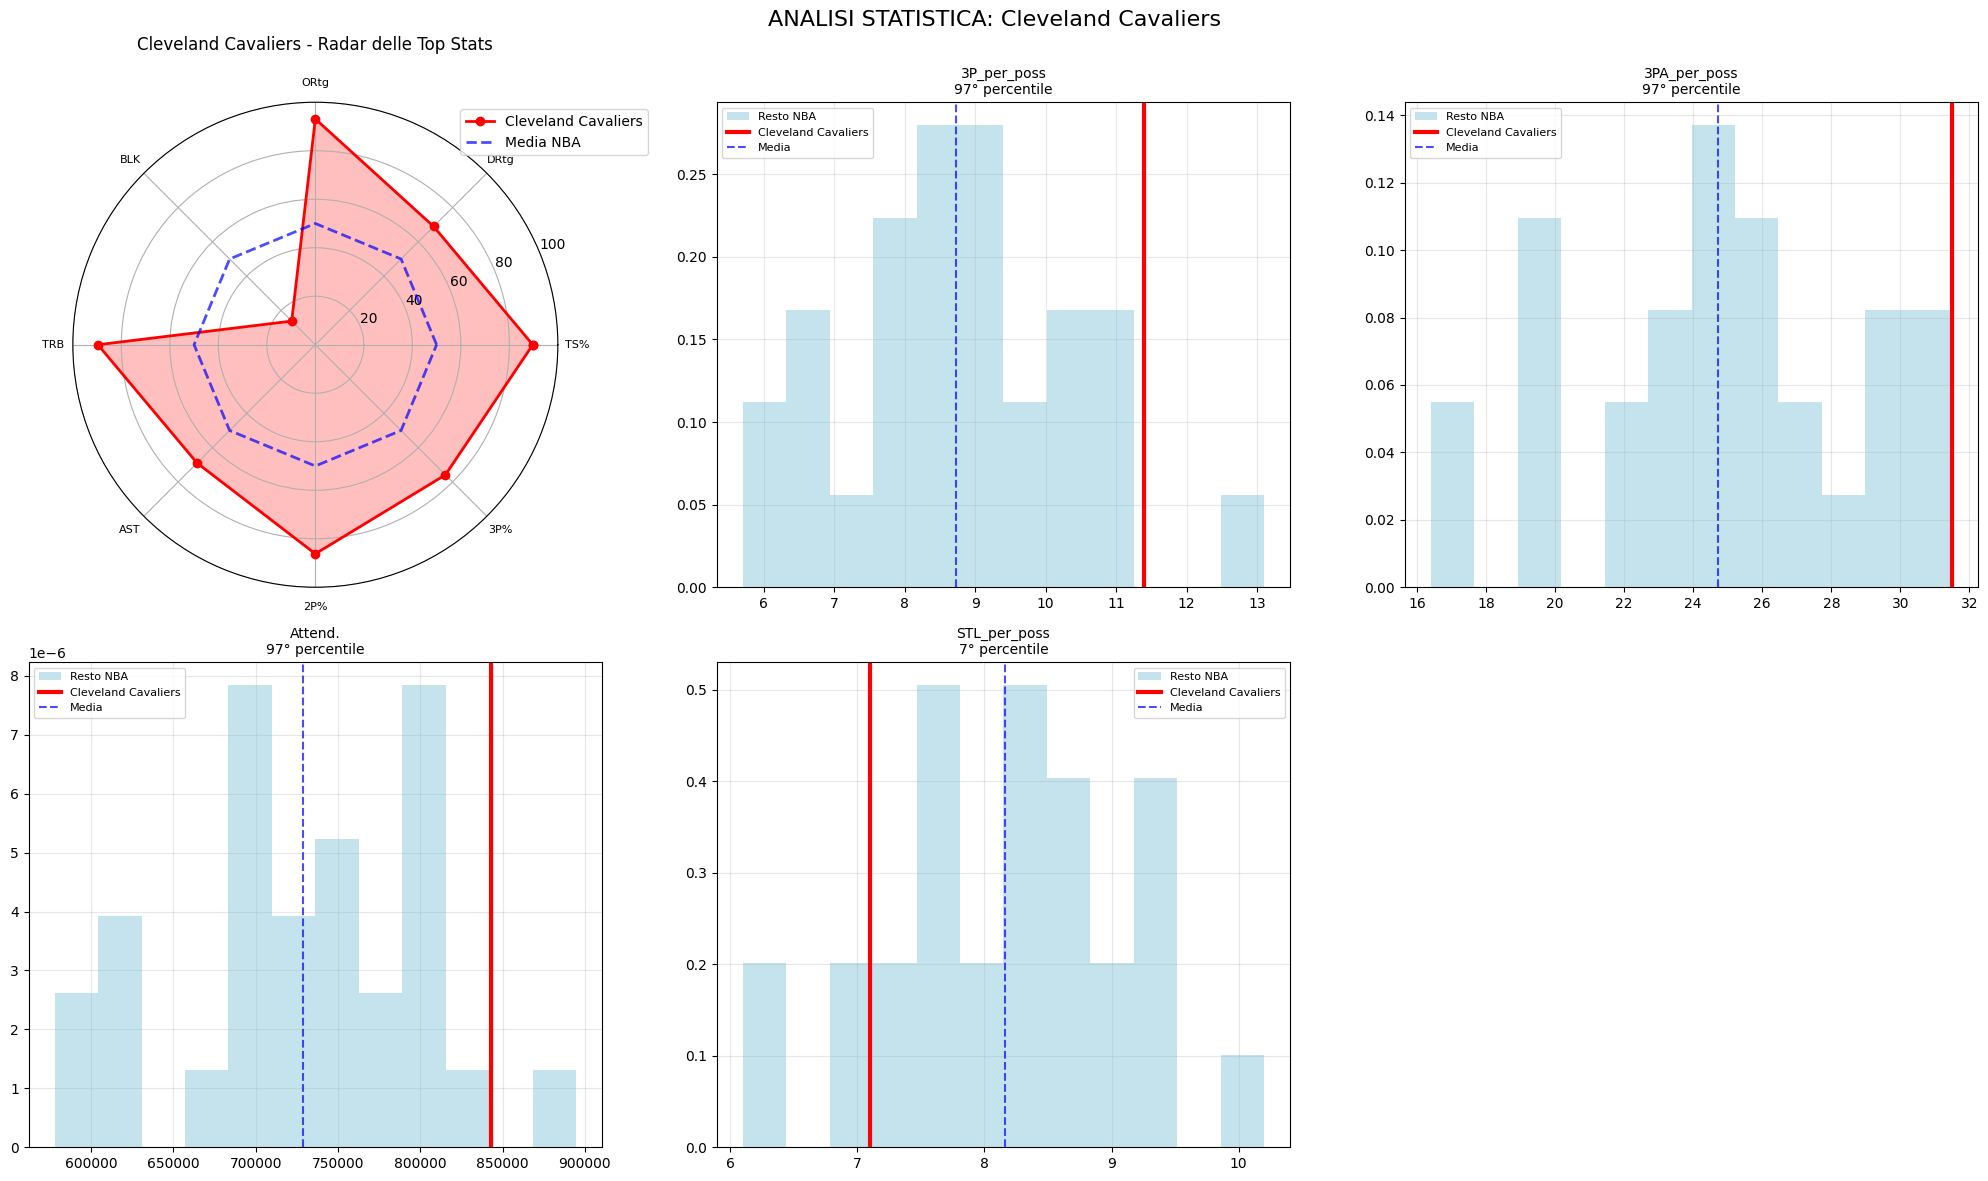

----------------------------------------
PUNTI DI FORZA (>= 70° percentile): 17
   • 3P_per_poss: 11.40 ↑ (97°)
   • 3PA_per_poss: 31.50 ↑ (97°)
   • Attend.: 843042.00 ↑ (97°)
   • PTS_per_poss: 110.90 ↑ (93°)
   • W: 57.00 ↑ (93°)
   • L: 25.00 ↓ (93°)
   • ORtg: 110.90 ↑ (93°)
   • 3PAr: 0.35 ↑ (93°)

DEBOLEZZE (<= 30° percentile): 6
   • STL_per_poss: 7.10 ↑ (7°)
   • Pace: 93.30 ↑ (7°)
   • BLK_per_poss: 4.10 ↑ (14°)


In [44]:
single_champ = analizza_campione(2016, scraping_functions_champ)

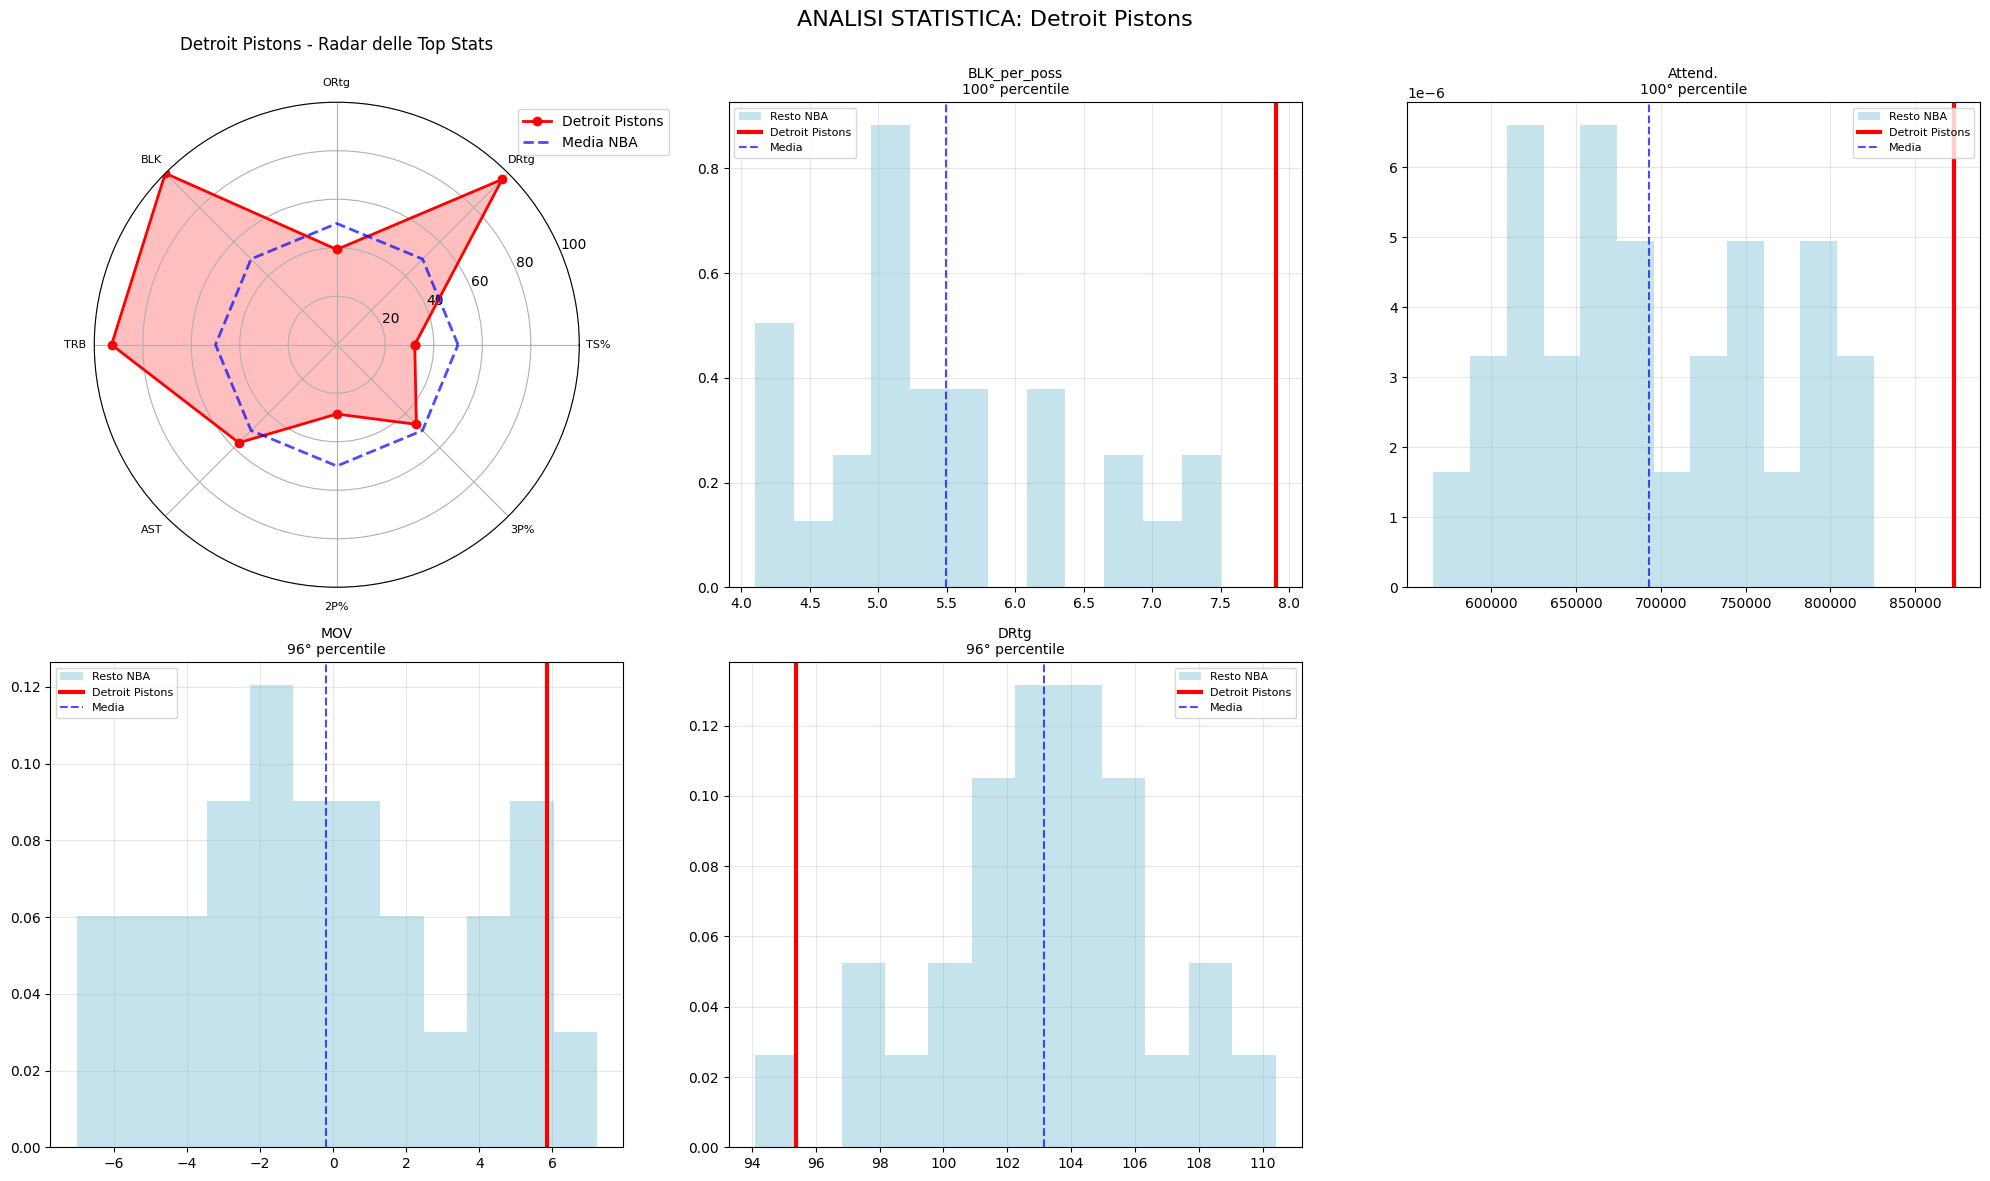

----------------------------------------
PUNTI DI FORZA (>= 70° percentile): 14
   • BLK_per_poss: 7.90 ↑ (100°)
   • Attend.: 872902.00 ↑ (100°)
   • MOV: 5.84 ↑ (96°)
   • DRtg: 95.40 ↓ (96°)
   • TRB_per_poss: 48.40 ↑ (93°)
   • NRtg: 6.60 ↑ (93°)
   • FT_per_poss: 21.60 ↑ (86°)
   • DRB_per_poss: 34.40 ↑ (86°)

DEBOLEZZE (<= 30° percentile): 6
   • 3PA_per_poss: 13.40 ↑ (14°)
   • 3PAr: 0.15 ↑ (14°)
   • 3P_per_poss: 4.60 ↑ (18°)


In [45]:
single_champ = analizza_campione(2004, scraping_functions_champ)

In [32]:
# TEAM STATS (from start_year to end_year)

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

class ChampionshipPatternsAnalyzer:
    
    def __init__(self):

        self.champions = champions
        
        # stats "inverse" --> valori bassi, better
        self.inverse_stats = {
            'TOV', 'DRtg', 'PF', 'TOV%', 'PTS_Opp', 'FG%_Opp', 'eFG%_Opp', 
            'TS%_Opp', 'ORtg_Opp', '3P%_Opp', 'FT%_Opp', 'TRB_Opp', 'AST_Opp'
        }
        
        # stats escluse dall'analisi
        self.excluded_stats = {
            'W', 'L', 'SOS', 'SRS', 'PW', 'LW', 'Att.', 'Season', 'IsChampion', 
            'Team', 'Tm', 'Rk', 'PL', 'G', 'MP'
        }
        
        # stats chiave
        self.key_stats = [
            # OFF_efficiency
            'ORtg', 'TS%', 'eFG%', '3PAr', '3P%', 'FT%', 'FTr',
            # DEF_efficiency  
            'DRtg', 'STL%', 'BLK%', 'DRB%',
            # controllo del gioco
            'AST%', 'TOV%', 'TRB%', 'ORB%',
            # stile di gioco
            'Pace', 'FGAr', 'PTS', 'FG%',
            # net Rating
            'NRtg'
        ]
    
    def _is_inverse_stat(self, stat_name):
        return any(inverse in stat_name for inverse in self.inverse_stats)
    
    def _calculate_percentile(self, value, others_values, stat_name):

        if self._is_inverse_stat(stat_name):
            percentile = (others_values > value).mean() * 100
        else:
            percentile = (others_values < value).mean() * 100
        return percentile
    
    def analyze_championship_patterns(self, scraping_functions, start_year, end_year):
        
        seasons_to_analyze = [year for year in range(start_year, end_year + 1) if year in self.champions]
        
        # raccolta dati
        champions_data, all_teams_data = self._collect_data(seasons_to_analyze, scraping_functions)
        
        if champions_data.empty:
            print("Nessun dato raccolto")
            return None
        
        # analisi modelli
        results = self._dual_model_analysis(champions_data, all_teams_data)
        
        # visualizzazioni
        self._create_visualizations(champions_data, all_teams_data, results)
        
        return results
    
    def _collect_data(self, seasons, scraping_functions):
        
        all_champions_data = []
        all_teams_data = []
        
        for i, season in enumerate(seasons):
            
            season_data = self._load_season_data(season, scraping_functions)
            
            if season_data is not None and not season_data.empty:
                champion_abbr = self.champions[season]
                
                season_data['Season'] = season
                season_data['IsChampion'] = (season_data['Team'] == champion_abbr).astype(int)
                
                champion_row = season_data[season_data['IsChampion'] == 1]
                
                if not champion_row.empty:
                    all_champions_data.append(champion_row)
                    all_teams_data.append(season_data)
                else:
                    print(f"{champion_abbr} non trovato")
            else:
                print("Nessun dato")
        
        # combina dati
        champions_df = pd.concat(all_champions_data, ignore_index=True) if all_champions_data else pd.DataFrame()
        all_teams_df = pd.concat(all_teams_data, ignore_index=True) if all_teams_data else pd.DataFrame()
        
        print(f"Squadre totali: {len(all_teams_df)}")
        
        return champions_df, all_teams_df
    
    def _load_season_data(self, season, scraping_functions):

        function_priority = ['team_advanced', 'team_per_poss', 'team_per_game']
        
        for func in function_priority:
            if func in scraping_functions and scraping_functions[func]:
                df = scraping_functions[func](season)
                
                if df is not None and not df.empty and 'Team' in df.columns:
                    df = df[df['Team'] != 'League Average'].copy()
                    if not df.empty:
                        return df
        
        return None
    
    def _dual_model_analysis(self, champions_df, all_teams_df):

        numeric_cols = []
        for col in champions_df.columns:
            if col not in self.excluded_stats:
                try:
                    if pd.api.types.is_numeric_dtype(champions_df[col]) and not champions_df[col].isna().all():
                        numeric_cols.append(col)
                except(KeyError, TypeError):
                    continue
        
        # priorità alle statistiche chiave
        available_key_stats = [stat for stat in self.key_stats if stat in numeric_cols]
        if available_key_stats:
            numeric_cols = available_key_stats + [col for col in numeric_cols if col not in available_key_stats]
    
        if len(numeric_cols) < 5:
            return {'error': 'Dati insufficienti per ML'}
        
        # MODELLO 1: Random Forest
        model_1 = self._random_forest_analysis(champions_df, all_teams_df, numeric_cols)
        
        # MODELLO 2: Logistic Regression
        model_2 = self._logistic_regression_analysis(champions_df, all_teams_df, numeric_cols)
        
        # percentili per pattern consistency
        percentile_results = self._percentile_analysis(champions_df, all_teams_df, numeric_cols)
        
        # consensus
        consensus = self._consensus(model_1, model_2, percentile_results)
        
        return {
            'model1': model_1,
            'model2': model_2,
            'percentiles': percentile_results,
            'consensus': consensus,
            'num_champions': len(champions_df),
            'key_stats_found': available_key_stats
        }
    
    def _random_forest_analysis(self, champions_df, all_teams_df, numeric_cols):

        # label da prevedere: 'IsChampion'
        
        X = all_teams_df[numeric_cols].fillna(all_teams_df[numeric_cols].median()) # feature (indipendenti)
        y = all_teams_df['IsChampion'] # target
        
        # bilanciamento dataset
        champion_indices = np.where(y == 1)[0]
        non_champion_indices = np.where(y == 0)[0]
        
        selected_non_champions = np.random.choice(
            non_champion_indices, 
            size=min(len(champion_indices) * 8, len(non_champion_indices)), 
            replace=False
        )
        balanced_indices = np.concatenate([champion_indices, selected_non_champions])
        
        X_balanced = X.iloc[balanced_indices]
        y_balanced = y.iloc[balanced_indices]

        # addestramento
        rf = RandomForestClassifier(
            n_estimators=300, 
            random_state=42, 
            max_depth=12,
            min_samples_split=3,
            min_samples_leaf=2
        )
        rf.fit(X_balanced, y_balanced)

        importance = pd.Series(rf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
                
        return {'importance': importance.head(12).to_dict()}
    
    def _logistic_regression_analysis(self, champions_df, all_teams_df, numeric_cols):
        
        X = all_teams_df[numeric_cols].fillna(all_teams_df[numeric_cols].median())
        y = all_teams_df['IsChampion']
        
        # bilancia
        champion_indices = np.where(y == 1)[0]
        non_champion_indices = np.where(y == 0)[0]
        
        selected_non_champions = np.random.choice(
            non_champion_indices, 
            size=min(len(champion_indices) * 6, len(non_champion_indices)), 
            replace=False
        )
        balanced_indices = np.concatenate([champion_indices, selected_non_champions])
        
        X_balanced = X.iloc[balanced_indices]
        y_balanced = y.iloc[balanced_indices]

        # standardizzazione per LR
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_balanced)
        
        lr = LogisticRegression(random_state=42, max_iter=1500, C=0.1)
        lr.fit(X_scaled, y_balanced)
        
        coefficients = pd.Series(np.abs(lr.coef_[0]), index=numeric_cols).sort_values(ascending=False)
        
        return {'coefficients': coefficients.head(12).to_dict()}
    
    def _percentile_analysis(self, champions_df, all_teams_df, numeric_cols):
        
        consistent_patterns = []
        
        for stat in numeric_cols:
            try:
                percentiles = []
                
                for _, champion_row in champions_df.iterrows():
                    season = champion_row['Season']
                    champ_value = champion_row[stat]
                    
                    if pd.notna(champ_value):
                        others = all_teams_df[
                            (all_teams_df['Season'] == season) & 
                            (all_teams_df['IsChampion'] == 0)
                        ][stat].dropna()
                        
                        if len(others) > 0:
                            percentile = self._calculate_percentile(champ_value, others, stat)
                            percentiles.append(percentile)
                
                if len(percentiles) >= 3:
                    avg_percentile = np.mean(percentiles)
                    consistency = 1 - (np.std(percentiles) / 100)
                    
                    # pattern ricorrent se percentile alto + alta consistenza
                    if (avg_percentile >= 75 or avg_percentile <= 25) and consistency >= 0.6:
                        consistent_patterns.append({
                            'stat': stat,
                            'avg_percentile': avg_percentile,
                            'consistency': consistency,
                            'strength': abs(avg_percentile - 50) * consistency
                        })
                        
            except Exception:
                continue
        
        consistent_patterns.sort(key=lambda x: x['strength'], reverse=True)
        
        return {'patterns': consistent_patterns[:12]}
    
    def _consensus(self, model1, model2, percentiles):
        
        rf_features = set(model1['importance'].keys())
        lr_features = set(model2['coefficients'].keys())
        percentile_features = set([p['stat'] for p in percentiles['patterns']])
        
        # consensus totale e parziale
        full_consensus = rf_features & lr_features & percentile_features
        partial_consensus = (rf_features & lr_features) | (rf_features & percentile_features) | (lr_features & percentile_features)
        
        # score consensus pesato
        consensus_scores = {}
        for feature in partial_consensus:
            score = 0
            
            # Random Forest weight
            if feature in model1['importance']:
                score += model1['importance'][feature] * 3
                
            # Logistic Regression weight
            if feature in model2['coefficients']:
                score += model2['coefficients'][feature] * 3
                
            # Percentile consistency weight
            for p in percentiles['patterns']:
                if p['stat'] == feature:
                    score += p['strength'] * 0.02
            
            consensus_scores[feature] = score
        
        sorted_consensus = sorted(consensus_scores.items(), key=lambda x: x[1], reverse=True)
        
        return {
            'full_consensus': list(full_consensus),
            'partial_consensus': list(partial_consensus),
            'ranking': sorted_consensus[:10],
            'top_winning_factors': sorted_consensus[:5]
        }
    
    def _create_visualizations(self, champions_df, all_teams_df, results):
        
        if 'error' in results:
            print("Dati insufficienti")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        try:
            # 1. Top Winning Factors (Consensus)
            top_factors = results['consensus']['top_winning_factors']
            if top_factors:
                factors = [item[0][:15] for item in top_factors]
                scores = [item[1] for item in top_factors]
                
                colors = ['gold', 'silver', 'peru', 'lightgray', 'sienna']
                bars = axes[0,0].barh(range(len(factors)), scores, 
                                     color=colors[:len(factors)], alpha=0.8)
                axes[0,0].set_yticks(range(len(factors)))
                axes[0,0].set_yticklabels(factors, fontsize=10)
                axes[0,0].set_title('TOP WINNING FACTORS', fontweight='bold', fontsize=12)
                axes[0,0].set_xlabel('Consensus Score')
                
                # Aggiungi valori sulle barre
                for i, (bar, score) in enumerate(zip(bars, scores)):
                    axes[0,0].text(score + max(scores)*0.01, i, f'{score:.3f}', 
                                  va='center', fontsize=9)
            
            # 2. efficiency comparison (ORtg vs DRtg)
            efficiency_stats = ['ORtg', 'DRtg', 'NRtg', 'TS%', 'eFG%', 'AST%']
            available_eff = [stat for stat in efficiency_stats if stat in champions_df.columns]
            
            if len(available_eff) >= 2:
                stat1, stat2 = available_eff[0], available_eff[1]

                others = all_teams_df[all_teams_df['IsChampion'] == 0]
                if len(others) > 200:
                    others = others.sample(200, random_state=42)
                    
                other_x = others[stat1].dropna()
                other_y = others[stat2].dropna()
                
                axes[0,1].scatter(other_x, other_y, alpha=0.4, c='lightblue', s=30, label='Other Teams')
                
                # champions con labels
                champions_clean = champions_df[[stat1, stat2, 'Season']].dropna()
                
                if not champions_clean.empty:
                    champ_x = champions_clean[stat1]
                    champ_y = champions_clean[stat2]
                    seasons = champions_clean['Season']
                    
                    # scatter champions
                    scatter = axes[0,1].scatter(champ_x, champ_y, alpha=0.9, c='red', s=100,
                                              label='Champions', edgecolor='darkred', linewidth=2)
                    
                    # labels con team name e year
                    for i, (x, y, season) in enumerate(zip(champ_x, champ_y, seasons)):
                        team_name = self.champions.get(season, 'sconosciuta')
                        label = f"{team_name}\n'{str(season)[-2:]}"
                        axes[0,1].annotate(label, (x, y), xytext=(5, 5), 
                                         textcoords='offset points', fontsize=8, 
                                         fontweight='bold', color='darkred',
                                         bbox=dict(boxstyle='round,pad=0.2', 
                                                  facecolor='white', alpha=0.8))
                
                axes[0,1].set_xlabel(f'{stat1}')
                axes[0,1].set_ylabel(f'{stat2}')
                axes[0,1].set_title(f'Champions: {stat1} vs {stat2}', fontweight='bold')
                axes[0,1].legend()
                axes[0,1].grid(True, alpha=0.3)
            
            # 3. Key Stat Distribution
            if top_factors:
                top_stat = top_factors[0][0]
                
                if top_stat in champions_df.columns and top_stat in all_teams_df.columns:
                    champion_values = champions_df[top_stat].dropna()
                    other_values = all_teams_df[all_teams_df['IsChampion'] == 0][top_stat].dropna()
                    
                    if len(champion_values) > 0 and len(other_values) > 0:
                        # Istogramma
                        axes[1,0].hist(other_values, bins=25, alpha=0.6, 
                                      label='Other Teams', color='lightblue', density=True)
                        axes[1,0].hist(champion_values, bins=8, alpha=0.9, 
                                      label='Champions', color='red', density=True)
                        
                        # mean lines
                        axes[1,0].axvline(champion_values.mean(), color='red', 
                                         linestyle='--', linewidth=2, label=f'Champions Avg: {champion_values.mean():.1f}')
                        axes[1,0].axvline(other_values.mean(), color='blue', 
                                         linestyle='--', linewidth=2, label=f'Others Avg: {other_values.mean():.1f}')
                        
                        axes[1,0].set_title(f'Distribution: {top_stat}', fontweight='bold')
                        axes[1,0].set_xlabel(top_stat)
                        axes[1,0].set_ylabel('Density')
                        axes[1,0].legend(fontsize=9)
                        axes[1,0].grid(True, alpha=0.3)
                    else:
                        axes[1,0].text(0.5, 0.5, 'Dati insufficienti', 
                                      ha='center', va='center', transform=axes[1,0].transAxes, 
                                      fontsize=12, bbox=dict(boxstyle="round", facecolor='white'))
                        axes[1,0].set_title('Distribution Analysis', fontweight='bold')
                else:
                    axes[1,0].text(0.5, 0.5, f'{top_stat}non disponibile', 
                                  ha='center', va='center', transform=axes[1,0].transAxes, 
                                  fontsize=12, bbox=dict(boxstyle="round", facecolor='white'))
                    axes[1,0].set_title('Distribution Analysis', fontweight='bold')
            else:
                axes[1,0].text(0.5, 0.5, 'Nessun fattore identificato', 
                              ha='center', va='center', transform=axes[1,0].transAxes, 
                              fontsize=12, bbox=dict(boxstyle="round", facecolor='white'))
                axes[1,0].set_title('Distribution Analysis', fontweight='bold')
            
            # 4. Percentile Heatmap (top stats consistency)
            consistent_patterns = results['percentiles']['patterns'][:6]
            if consistent_patterns and len(consistent_patterns) > 0:
                stats = [p['stat'][:10] for p in consistent_patterns]  # nome_stat: primi 10 char
                percentiles = [p['avg_percentile'] for p in consistent_patterns]
                consistency = [p['consistency'] * 100 for p in consistent_patterns]
                
                # matrice per heatmap
                matrix = np.array([percentiles, consistency]).T
                
                im = axes[1,1].imshow(matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
                axes[1,1].set_xticks([0, 1])
                axes[1,1].set_xticklabels(['Avg\nPercentile', 'Consistency %'], fontsize=10)
                axes[1,1].set_yticks(range(len(stats)))
                axes[1,1].set_yticklabels(stats, fontsize=9)
                axes[1,1].set_title('Pattern Consistency', fontweight='bold')
                
                # valori con colore adattivo
                for i in range(len(stats)):
                    for j in range(2):
                        value = matrix[i, j]
                        color = "white" if value > 50 else "black"
                        axes[1,1].text(j, i, f'{value:.0f}', 
                                     ha="center", va="center", color='black', 
                                     fontweight='bold', fontsize=10)
                
                # colorbar
                cbar = plt.colorbar(im, ax=axes[1,1], fraction=0.046, pad=0.04)
                cbar.set_label('Value', rotation=270, labelpad=15)
                
            else:
                axes[1,1].text(0.5, 0.5, 'consistency non disponibile', 
                              ha='center', va='center', transform=axes[1,1].transAxes, 
                              fontsize=12, bbox=dict(boxstyle="round", facecolor='white'))
                axes[1,1].set_title('Pattern Consistency', fontweight='bold')
            
            plt.suptitle('WINNING PATTERNS ANALYSIS', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"errore nella creazione grafici: {str(e)}")

def find_champs_pattern(scraping_functions, start_year, end_year):

    analyzer = ChampionshipPatternsAnalyzer()
    return analyzer.analyze_championship_patterns(scraping_functions, start_year, end_year)

In [33]:
# ROSTER ANALYSIS

import matplotlib.pyplot as plt
from collections import Counter

class ChampionshipAnalyzer:
    
    def __init__(self):

        self.champions = champions
        
        # soglie archetipi
        self.archetipi = {
            'Superstar/Primary Scorer': {
                # leader offensivo principale
                'soglie': {'USG%': 25, 'TS%': 0.58, 'PER': 17.5}
            },
            'Playmaker': {
                # creatore di gioco
                'soglie': {'AST%': 20, 'AST/TO': 2.0}
            },
            '3PT Shooter': {
                # specialista dal perimetro
                'soglie': {'3P%': 0.35, '3PA': 2.5}
            },
            'Rim Protector': {
                # difesa nel pitturato
                'soglie': {'Pos_adv': ['C', 'PF'], 'BLK%': 1.8, 'DRB%': 14}
            },
            'Perimeter Defender': {
                # specialista difensivo per esterni
                'soglie': {'Pos_adv': ['PG', 'SG', 'SF'], 'STL%': 1.5, 'DBPM': 1.0}
            },
            'Stretch Big': {
                # spacing 
                'soglie': {'Pos_adv': ['C', 'PF'], '3PAr': 0.25, '3P%': 0.30}
            },
            'All-around threat': {
                # tuttofare
                'soglie': {'TRB%': 10, 'AST%': 12, 'STL%': 1.2, 'BLK%': 1.6}
            },
            'Floor General': {
                # secondo gestore del pallone
                'soglie': {'TOV%': 15, 'AST/TO': 2.0}
            },
            'Veteran': {
                # esperienza
                'soglie': {'Age_adv': 34}
            }
        }
        
        # soglie per giocatori da considerare
        self.soglie_chiave = {
            'minuti_minimi': 10,
            'partite_minime': 30,
        }
    
    def analizza_championship_rosters(self, scraping_functions, start_year, end_year):
        
        seasons_to_analyze = [year for year in range(start_year, end_year + 1) if year in self.champions]
        
        # Raccolta e separazione dati
        champions_data, league_data = self._collect_champion_data(seasons_to_analyze, scraping_functions)
        
        if not champions_data or not league_data:
            print("Dati incompleti")
            return None
            
        # calcolo età
        champion_age_distributions = self.calculate_age_distributions(champions_data)
        league_age_distributions = self.calculate_age_distributions(league_data)
    
        # calcolo le percentuali medie per i campioni
        total_players_champ = [sum(dist.values()) for dist in champion_age_distributions]
        prime_pct = np.mean([d['prime_players']/t*100 for d, t in zip(champion_age_distributions, total_players_champ) if t > 0]) if total_players_champ else 0
        veteran_pct = np.mean([d['veterans']/t*100 for d, t in zip(champion_age_distributions, total_players_champ) if t > 0]) if total_players_champ else 0
        young_pct = np.mean([d['young_players']/t*100 for d, t in zip(champion_age_distributions, total_players_champ) if t > 0]) if total_players_champ else 0

        results = {
            'roster_compositions': self._analyze_roster_compositions(champions_data, league_data),
            'team_patterns': self._analyze_team_patterns(champions_data)
        }

        # passa i dati dell'età a results per report
        results['age_analysis'] = {
            'prime_pct': prime_pct,
            'veteran_pct': veteran_pct,
            'young_pct': young_pct
        }
        
        self._create_essential_visualizations(results, champions_data, league_data)
        
        return results
        
    def _collect_champion_data(self, seasons, scraping_functions):
    
        champions_data = {}
        league_data = {}
        
        for season in seasons:
            champion_team = self.champions.get(season)
            if not champion_team:
                print(f"nessun campione per la stagione {season}")
                continue
                
            try:
                # advanced, per_game, per_poss
                advanced_data = scraping_functions['single']('advanced', season, False)  
                per_game_data = scraping_functions['single']('per_game', season, False)
                per_poss_data = scraping_functions['single']('per_poss', season, False)
                
                if (advanced_data is None or advanced_data.empty or 
                    per_game_data is None or per_game_data.empty or
                    per_poss_data is None or per_poss_data.empty):
                    print("almeno un dataset è vuoto")
                    continue
                
                # merge
                merge_keys = ['Player', 'Season', 'Team']
                
                # verifico che le chiavi di merge esistano
                adv_keys = all(key in advanced_data.columns for key in merge_keys)
                pg_keys = all(key in per_game_data.columns for key in merge_keys)
                pp_keys = all(key in per_poss_data.columns for key in merge_keys)
                
                if not adv_keys or not pg_keys:
                    print(f"key merge mancanti - Adv: {adv_keys}, PG: {pg_keys}, PP: {pp_keys}")
                    continue
            
                # primo merge
                merged_data = pd.merge(
                    advanced_data, 
                    per_game_data, 
                    on=merge_keys, 
                    how='inner',  # solo giocatori presenti in entrambi
                    suffixes=('_adv', '_pg',)  # suffissi per colonne duplicate
                )

                # secondo merge
                merged_data = pd.merge(
                    merged_data,
                    per_poss_data,
                    on=merge_keys,
                    how='inner',
                    suffixes=('', '_poss')
                )
                
                if merged_data.empty:
                    print("merge vuoto")
                    continue
                
            except Exception as e:
                print(f"Errore nel merge: {e}")
                continue
            
            if 'Team' in merged_data.columns:
                # filtro giocatori chiave
                key_players = self._filter_key_players(merged_data)
    
                # separa i dati in base alla squadra campione
                champion_players = key_players[key_players['Team'] == champion_team].copy()
                rest_of_league_players = key_players[key_players['Team'] != champion_team].copy()
                
                if not champion_players.empty:
                    champions_data[season] = {
                        'champion': champion_team,
                        'season': season,
                        'players': champion_players,
                        'player_count': len(champion_players)
                    }
                
                if not rest_of_league_players.empty:
                    league_data[season] = {
                        'champion': champion_team,
                        'season': season,
                        'players': rest_of_league_players,
                        'player_count': len(rest_of_league_players)
                    }
            else:
                print(f"'Team' col mancante")
        
        return champions_data, league_data
    
    def _filter_key_players(self, player_data):
        
        filtered = player_data.copy()
        
        # minuti giocati
        if 'MP' in filtered.columns:
            try:
                mp_numeric = pd.to_numeric(filtered['MP'], errors='coerce')
                filtered = filtered[mp_numeric >= self.soglie_chiave['minuti_minimi']]
            except:
                pass
        
        # partite giocate
        if 'G' in filtered.columns:
            try:
                g_numeric = pd.to_numeric(filtered['G'], errors='coerce')
                filtered = filtered[g_numeric >= self.soglie_chiave['partite_minime']]
            except:
                pass
        
        return filtered.reset_index(drop=True)

    def calculate_age_distributions(self, data_dict):
        
        age_distributions = []
        
        if not data_dict:
            print("data_dict è vuoto o None")
            return age_distributions
        
        for season, data in data_dict.items():
            players = data['players']
            
            # ricerco colonna Age e possibili variazioni
            age_columns = [col for col in players.columns if 'age' in col.lower()]
        
            age_column = None
            if 'Age' in players.columns:
                age_column = 'Age'
            elif 'Age_adv' in players.columns:
                age_column = 'Age_adv'
            elif 'Age_pg' in players.columns:
                age_column = 'Age_pg'
            elif age_columns:
                age_column = age_columns[0]
            
            if age_column:
                
                ages = pd.to_numeric(players[age_column], errors='coerce').dropna()
                
                if len(ages)>0:
                    
                    young_count = len(ages[ages <= 24])
                    prime_count = len(ages[(ages > 24) & (ages < 30)])
                    veteran_count = len(ages[ages >= 30])
                    
                    age_profile = {
                        'young_players': young_count,
                        'prime_players': prime_count,  
                        'veterans': veteran_count
                    }
                    
                    age_distributions.append(age_profile)
                else:
                    print("Nessuna età valida dopo la conversione")
            else:
                print("Nessuna colonna età presente")

        return age_distributions
    
    def _analyze_roster_compositions(self, champions_data, league_data):
    
        def _calculate_archetype_percentages(data):
            all_percentages = {archetype: [] for archetype in self.archetipi.keys()}
            
            for season, team_data in data.items():
                team_name = team_data.get('champion', 'sconosciuto')
                players = team_data['players']
                
                team_archetipi_list = self._identify_player_archetypes(players)
                
                # se non ci sono archetipi, passo alla squadra successiva
                if not team_archetipi_list:
                    print("Nessun archetipo per questa squadra")
                    continue
                
                # conta archetipi
                archetype_counts = Counter(team_archetipi_list) # Counter per la frequenza per archetipi
                total_archetypes_count = len(team_archetipi_list)
            
                # calcola percentuali per ogni archetipo
                for archetype in self.archetipi.keys():
                    count = archetype_counts.get(archetype, 0)
                    percentage = (count / total_archetypes_count) * 100
                    all_percentages[archetype].append(percentage)
            
            return all_percentages
    
        # calcola le percentuali per i campioni e per il resto della lega
        champion_percentages_list = _calculate_archetype_percentages(champions_data)
        league_percentages_list = _calculate_archetype_percentages(league_data)
    
        roster_analysis = {
            'champion_avg_percentages': {arch: np.mean(vals) if vals else 0 for arch, vals in champion_percentages_list.items()},
            'league_avg_percentages': {arch: np.mean(vals) if vals else 0 for arch, vals in league_percentages_list.items()},
            'archetype_frequency': {},
            'essential_roles': []
        }

        print(f"\nCONFRONTO - MEDIE PERCENTUALI:")
        print(f"{'Archetipo':<25} {'Campioni':<12} {'Lega':<12} {'Differenza':<12}")
        
        for archetype in self.archetipi.keys():
            champ_avg = roster_analysis['champion_avg_percentages'][archetype]
            league_avg = roster_analysis['league_avg_percentages'][archetype]
            diff = champ_avg - league_avg
            
            print(f"{archetype:<25} {champ_avg:>8.1f}%    {league_avg:>8.1f}%    {diff:>+8.1f}%")
        
        # calcola frequenza archetipi (quante squadre campioni hanno questo archetipo)
        total_champion_teams = len(champions_data)
        for archetype in self.archetipi.keys():
            teams_with_archetype = len([perc for perc in champion_percentages_list[archetype] if perc > 0])
            frequency = teams_with_archetype / total_champion_teams if total_champion_teams > 0 else 0
        
            roster_analysis['archetype_frequency'][archetype] = {
                'frequency': frequency,
                'count': teams_with_archetype,
                'total_teams': total_champion_teams
            }
        
        return roster_analysis
    
    def _identify_player_archetypes(self, players):
        
        players_with_archetypes = 0
        total_archetypes_assigned = 0
        
        team_archetipi = []
        
        for i, player in players.iterrows():
            player_name = player.get('Player', f'Player_{i}')
            player_archetypes = []  # lista degli archetipi per questo giocatore
            
            # valuta ogni archetipo per ogni giocatore
            for archetype in self.archetipi.keys():
                config = self.archetipi[archetype]
                soglie = config['soglie']
                criteri_soddisfatti = 0
                criteri_totali = len(soglie)
                
                for stat, threshold in soglie.items():
                    if stat in ['Pos_adv']:
                        if player.get(stat, 'N/A') in threshold:
                            criteri_soddisfatti += 1
                    elif stat in ['AST/TO']:
                        ast = pd.to_numeric(player.get('AST', 0), errors='coerce') or 0
                        tov = pd.to_numeric(player.get('TOV', 0), errors='coerce') or 1
                        value = ast / tov
                        if pd.notna(value) and value >= threshold:
                            criteri_soddisfatti += 1
                    elif stat in ['TOV%']:
                        value = pd.to_numeric(player.get(stat, 0), errors='coerce')
                        if pd.notna(value) and value <= threshold:
                            criteri_soddisfatti += 1
                    elif archetype == 'Veteran':
                        if pd.to_numeric(player.get('Age_adv', 0), errors='coerce') >= threshold:
                            criteri_soddisfatti += 1
                    else:
                        value = pd.to_numeric(player.get(stat, 0), errors='coerce')
                        if pd.notna(value) and value >= threshold:
                            criteri_soddisfatti += 1
    
                # se soddisfa almeno 2/3 dei criteri, aggiungo l'archetipo
                if criteri_totali > 0 and criteri_soddisfatti >= criteri_totali * 0.65:
                    player_archetypes.append(archetype)
        
            # aggiungo tutti gli archetipi del giocatore alla lista totale
            if player_archetypes:
                team_archetipi.extend(player_archetypes)
                players_with_archetypes += 1
                total_archetypes_assigned += len(player_archetypes)
        
        return team_archetipi
    
    def _analyze_team_patterns(self, champions_data):
        
        patterns = {
            'roster_sizes': [],
            'age_distributions': [],
        }
        
        for season, data in champions_data.items():
            players = data['players']
            
            patterns['roster_sizes'].append(len(players))
            
            # Age distribution
            if 'Age' in players.columns:
                ages = pd.to_numeric(players['Age'], errors='coerce').dropna()
                if len(ages) > 0:
                    age_profile = {
                        'avg_age': ages.mean(),
                        'young_players': len(ages[ages <= 24]),
                        'prime_players': len(ages[(ages > 24) & (ages < 30)]),
                        'veterans': len(ages[ages >= 30])
                    }
                    patterns['age_distributions'].append(age_profile)
        
        return patterns
    
    def _create_essential_visualizations(self, results, champions_data, league_data):
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
        # 1. confronto Roster Campioni vs Lega (percentuali delle medie)
        ax1 = axes[0, 0]
        
        champion_avg_percentages = results['roster_compositions']['champion_avg_percentages']
        league_avg_percentages = results['roster_compositions']['league_avg_percentages']
    
        if champion_avg_percentages and league_avg_percentages:
            archetipi = sorted(champion_avg_percentages.keys())
            champions_values = [champion_avg_percentages[a] for a in archetipi]
            league_values = [league_avg_percentages[a] for a in archetipi]
            
            x = np.arange(len(archetipi))
            width = 0.35
            
            ax1.bar(x - width/2, champions_values, width, label='Campioni', color='navy', alpha=0.9)
            ax1.bar(x + width/2, league_values, width, label='Resto della Lega', color='skyblue', alpha=0.7)
            
            ax1.set_xticks(x)
            ax1.set_xticklabels(archetipi, rotation=45, ha='right')
            ax1.set_ylabel('Percentuale Media (%)', fontweight='bold')
            ax1.set_title('Composizione Roster: Campioni vs Resto della Lega', fontweight='bold', fontsize=12)
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)

        # 2. distribuzione età champs vs media lega
        ax2 = axes[0, 1]
        
        # calcola le distribuzioni per età per campioni e lega
        champion_age_distributions = self.calculate_age_distributions(champions_data)
        league_age_distributions = self.calculate_age_distributions(league_data)
        
        if champion_age_distributions and league_age_distributions:
            # CHAMPS
            total_young_champ = sum([dist['young_players'] for dist in champion_age_distributions])
            total_prime_champ = sum([dist['prime_players'] for dist in champion_age_distributions])
            total_veterans_champ = sum([dist['veterans'] for dist in champion_age_distributions])
            total_players_champ = total_young_champ + total_prime_champ + total_veterans_champ
            
            # calcola percentuali medie
            if total_players_champ > 0:
                champions_pct = [
                    (total_young_champ / total_players_champ) * 100,
                    (total_prime_champ / total_players_champ) * 100,
                    (total_veterans_champ / total_players_champ) * 100
                ]
            else:
                champions_pct = [0, 0, 0]
            
            # LEGA
            total_young_league = sum([dist['young_players'] for dist in league_age_distributions])
            total_prime_league = sum([dist['prime_players'] for dist in league_age_distributions])
            total_veterans_league = sum([dist['veterans'] for dist in league_age_distributions])
            total_players_league = total_young_league + total_prime_league + total_veterans_league
    
            # Calcola percentuali medie
            if total_players_league > 0:
                league_pct = [
                    (total_young_league / total_players_league) * 100,
                    (total_prime_league / total_players_league) * 100,
                    (total_veterans_league / total_players_league) * 100
                ]
            else:
                league_pct = [0, 0, 0]
            
            # PLOT
            x = np.arange(3)
            width = 0.35
            
            bars1 = ax2.bar(x - width/2, champions_pct, width, label='Campioni',  
                           color=['gold', 'gold', 'gold'], alpha=0.8, edgecolor='black')
            bars2 = ax2.bar(x + width/2, league_pct, width, label='Resto Lega',  
                           color=['silver', 'silver', 'silver'], alpha=0.6, edgecolor='black')
            
            ax2.set_ylabel('Percentuale Roster (%)', fontweight='bold')
            ax2.set_title('Composizione Età: Campioni vs Resto Lega', fontweight='bold', fontsize=12)
            ax2.set_xticks(x)
            ax2.set_xticklabels(['Prospetti\n(<=24)', 'Prime\n(25-29)', 'Veterani\n(>=30)'])
            ax2.legend()
            ax2.grid(axis='y', alpha=0.3)
        
            # annotazioni con valori percentuali
            for bars, values in [(bars1, champions_pct), (bars2, league_pct)]:
                for bar, val in zip(bars, values):
                    if val > 0:
                        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        else:
            # se non ci sono dati età
            ax2.text(0.5, 0.5, 'Dati età non disponibili', ha='center', va='center', 
                     transform=ax2.transAxes, fontsize=14)
            ax2.set_title('Composizione età: Dati non disponibili', fontweight='bold', fontsize=12)
                
        # 3. composizione Core vs Role Players
        ax3 = axes[1, 0]
        
        # definisco le categorie di archetipi
        archetype_categories = {
            'Core_Players': ['Superstar/Primary Scorer', 'Playmaker', '3PT Shooter', 'All-around threat'],
            'Role_Players': ['Perimeter Defender', 'Rim Protector', 'Floor General', 'Stretch Big', 'Veteran']
        }
        
        # calcola le percentuali per campioni e lega
        def _calculate_category_percentages(data):

            core_percentages = []
            role_percentages = []
            
            for season, team_data in data.items():
                players = team_data['players']
                team_archetipi_list = self._identify_player_archetypes(players)
                
                if not team_archetipi_list:
                    continue
                
                # conta archetipi per categoria
                core_count = sum(1 for arch in team_archetipi_list if arch in archetype_categories['Core_Players'])
                role_count = sum(1 for arch in team_archetipi_list if arch in archetype_categories['Role_Players'])
                total_count = len(team_archetipi_list)
                
                if total_count > 0:
                    core_pct = (core_count / total_count) * 100
                    role_pct = (role_count / total_count) * 100
                    core_percentages.append(core_pct)
                    role_percentages.append(role_pct)
            
            return {
                'core_avg': np.mean(core_percentages) if core_percentages else 0,
                'role_avg': np.mean(role_percentages) if role_percentages else 0
            }
        
        champion_categories = _calculate_category_percentages(champions_data)
        league_categories = _calculate_category_percentages(league_data)
        
        # dati per il grafico a barre
        categories = ['Campioni', 'Resto Lega']
        core_values = [champion_categories['core_avg'], league_categories['core_avg']]
        role_values = [champion_categories['role_avg'], league_categories['role_avg']]
        
        # crea barre
        bars1 = ax3.bar(categories, core_values, label='Core Players', 
                        color='darkred', alpha=0.8, edgecolor='black')
        bars2 = ax3.bar(categories, role_values, bottom=core_values, label='Role Players', 
                        color='lightcoral', alpha=0.8, edgecolor='black')
        
        ax3.set_ylabel('Percentuale Media Archetipi (%)', fontweight='bold')
        ax3.set_title('Composizione Core vs Role Players', fontweight='bold', fontsize=12)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    
        # annotazioni sui valori
        for i, (core, role) in enumerate(zip(core_values, role_values)):
            if core > 0:
                ax3.text(i, core/2, f'{core:.1f}%', ha='center', va='center', 
                        fontweight='bold', color='white', fontsize=10)
            if role > 0:
                ax3.text(i, core + role/2, f'{role:.1f}%', ha='center', va='center', 
                        fontweight='bold', color='black', fontsize=10)
            
            # tot in cima
            total = core + role
            if total > 0:
                ax3.text(i, total + 1, f'Tot: {total:.1f}%', ha='center', va='bottom', 
                        fontweight='bold', fontsize=9)

        ax4 = axes[1,1]
        fig.delaxes(ax4)
        
        plt.suptitle('ANALISI AVANZATA COMPOSIZIONE ROSTER CAMPIONI NBA', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
# funzione principale
def analyze_champions(scraping_functions, start_year=2015, end_year=2024):

    analyzer = ChampionshipAnalyzer()

    return analyzer.analizza_championship_rosters(scraping_functions, start_year, end_year)

In [42]:
# PLAYOFF ANALYSIS

import matplotlib.pyplot as plt

class PlayoffAnalyzer:
    
    def __init__(self):

        self.champions = champions
        
        # key stats per analisi RS vs PO
        self.key_stats_rs_vs_po = {
            'Pace': {'higher_better': True},   # possessions per 48 minuti
            'TS%': {'higher_better': True},    # True Shooting %
            'TOV%': {'higher_better': False},  # % palloni persi
            'FTr': {'higher_better': True},    # rapporto FT/FGA
            'ORtg': {'higher_better': True},   # punti per 100 poss
            'DRtg': {'higher_better': False}   # punti allowed per 100 poss
        }
        
        # stats per confronto Campioni vs Lega nei PO
        self.key_stats_champions_vs_league_po = {
            'TS%': {'higher_better': True},
            'NRtg': {'higher_better': True}, # ORtg - DRtg
            'Pace': {'higher_better': True}, 
            'Off_eFG%': {'higher_better': True}, # effective FG%
            'Off_ORB%': {'higher_better': True},
            'DRB%': {'higher_better': True},
            'AST%': {'higher_better': True}, 
            'STL%': {'higher_better': True},
            'BLK%': {'higher_better': True}
        }
    
    def analyze_playoff_performance(self, scraping_functions, start_year, end_year):
        
        seasons_to_analyze = [year for year in range(start_year, end_year + 1) if year in self.champions]
        
        # raccolta dati
        rs_data, po_data = self._collect_team_data(seasons_to_analyze, scraping_functions)
        
        if not rs_data or not po_data:
            print("Dati incompleti")
            return None
        
        # Analisi 1: RS vs PO nei campioni
        rs_vs_po_analysis = self._analyze_champions_rs_vs_po(rs_data, po_data)
        
        # Analisi 2: campioni vs lega ai PO
        champions_vs_league_analysis = self._analyze_champions_vs_league_playoffs(po_data)
        
        results = {
            'rs_vs_po_analysis': rs_vs_po_analysis,
            'champions_vs_league_po': champions_vs_league_analysis,
            'seasons_analyzed': seasons_to_analyze
        }
        
        self._create_playoff_visualizations(results)
        
        self._playoff_report(results)
        
        return results
    
    def _collect_team_data(self, seasons, scraping_functions):
    
        rs_data = {}
        po_data = {} 
        
        for season in seasons:
            champion_team = self.champions.get(season)
            if not champion_team:
                print(f"nessun campione per {season}")
                continue
            
            try:
                # RS
                rs_advanced = scraping_functions['team_advanced'](season)
                rs_per_game = scraping_functions['team_per_game'](season)
                rs_per_poss = scraping_functions['team_per_poss'](season)
                
                # PO
                po_advanced = scraping_functions['team_advanced_PO'](season).head(16)
                po_per_game = scraping_functions['team_per_game_PO'](season).head(16)
                po_per_poss = scraping_functions['team_per_poss_PO'](season).head(16)
                
                # verifica validità
                rs_datasets = [rs_advanced, rs_per_game, rs_per_poss]
                po_datasets = [po_advanced, po_per_game, po_per_poss]
                
                if any(df is None or df.empty for df in rs_datasets + po_datasets):
                    print("Dati incompleti")
                    continue
                
                # merge dei dataset
                rs_merged = self._merge_team_datasets(rs_advanced, rs_per_game, rs_per_poss)
                po_merged = self._merge_team_datasets(po_advanced, po_per_game, po_per_poss)
                
                if rs_merged is not None and po_merged is not None:
                    rs_data[season] = {
                        'champion': champion_team,
                        'data': rs_merged,
                        'champion_data': rs_merged[rs_merged['Team'] == champion_team] if 'Team' in rs_merged.columns else None
                    }
                    
                    po_data[season] = {
                        'champion': champion_team,
                        'data': po_merged,
                        'champion_data': po_merged[po_merged['Team'] == champion_team] if 'Team' in po_merged.columns else None
                    }

                else:
                    print("Merge fallito")
                    
            except Exception as e:
                print(f"Errore: {e}")
                continue

        return rs_data, po_data
    
    def _merge_team_datasets(self, advanced_df, per_game_df, per_poss_df):

        try:
            datasets = [advanced_df, per_game_df, per_poss_df]
            
            # standardizza la colonna del team per ogni df
            for df in datasets:
                if df is not None:
                    if 'Tm' in df.columns:
                        df.rename(columns={'Tm': 'Team'}, inplace=True)
                    elif 'Team' not in df.columns:
                        # se non esiste, errore
                        raise ValueError("Colonna 'Team' o 'Tm' non trovata in un DataFrame")
            
            # rimuovi le colonne ridondanti se presenti            
            if per_game_df is not None:
                # rimuovo 'Rk' da per_game per evitare duplicati
                if 'Rk' in per_game_df.columns:
                    per_game_df = per_game_df.drop(columns=['Rk'], errors='ignore')
            
            if per_poss_df is not None:
                # rimuovo 'Rk', 'G', 'MP' da per_poss_df per evitare duplicati
                cols_to_drop = ['Rk', 'G', 'MP']
                per_poss_df = per_poss_df.drop(columns=[col for col in cols_to_drop if col in per_poss_df.columns], errors='ignore')
    
            # merge progressivo con i suffissi
            merge = pd.merge(advanced_df, per_game_df, on='Team', how='inner', suffixes=('', '_pg'))
            merge = pd.merge(merge, per_poss_df, on='Team', how='inner', suffixes=('', '_poss'))
            
            return merge
    
        except Exception as e:
            print(f"Errore merge: {e}")
            return None
    
    def _analyze_champions_rs_vs_po(self, rs_data, po_data):
        
        analysis = {
            'stat_changes': {},
            'average_changes': {},
            'season_details': {}
        }
        
        for season in rs_data.keys():
            if season not in po_data:
                continue
                
            champion_team = rs_data[season]['champion']
            rs_champion = rs_data[season]['champion_data']
            po_champion = po_data[season]['champion_data']
            
            if rs_champion is None or po_champion is None or rs_champion.empty or po_champion.empty:
                print(f"Dati campione mancanti per {season}")
                continue
            
            season_changes = {}
            
            for stat in self.key_stats_rs_vs_po.keys():
                try:
                    rs_value = pd.to_numeric(rs_champion[stat].iloc[0], errors='coerce')
                    po_value = pd.to_numeric(po_champion[stat].iloc[0], errors='coerce')
                    
                    # calcola cambiamento percentuale
                    if pd.notna(rs_value) and pd.notna(po_value) and rs_value != 0:
                        pct_change = ((po_value - rs_value) / rs_value) * 100
                        season_changes[stat] = {
                            'rs_value': rs_value,
                            'po_value': po_value,
                            'change': po_value - rs_value,
                            'pct_change': pct_change
                        }
                except Exception as e:
                    continue
            
            if season_changes:
                analysis['season_details'][season] = {
                    'champion': champion_team,
                    'changes': season_changes
                }
        
        # calcola medie dei cambiamenti
        for stat in self.key_stats_rs_vs_po.keys():
            changes = []
            pct_changes = []
        
            for season_data in analysis['season_details'].values():
                if stat in season_data['changes']:
                    changes.append(season_data['changes'][stat]['change'])
                    pct_changes.append(season_data['changes'][stat]['pct_change'])
            
            if changes:
                analysis['average_changes'][stat] = {
                    'avg_change': np.mean(changes),
                    'avg_pct_change': np.mean(pct_changes),
                    'samples': len(changes)
                }
        
        return analysis

    def _analyze_champions_vs_league_playoffs(self, po_data):
        
        analysis = {
            'champion_averages': {},
            'league_averages': {},
            'differences': {}
        }

        # statistiche per controllo del gioco
        all_stats_to_analyze = {**self.key_stats_champions_vs_league_po} # crea una copia di self.key_stats...
        
        # aggiungi statistiche di controllo del gioco
        game_control_stats = {
            'Off_eFG%': {'higher_better': True},
            'Off_ORB%': {'higher_better': True},
            'Off_TOV%': {'higher_better': False},
            'Def_eFG%': {'higher_better': False},  # opponent eFG%
            'Def_DRB%': {'higher_better': True},
            'Def_TOV%': {'higher_better': True}    # opponent TOV%
        }
    
        all_stats_to_analyze.update(game_control_stats)
        
        # raccogli stats per campioni e resto lega
        all_champion_stats = {stat: [] for stat in all_stats_to_analyze.keys()}  # dictionary comprehension,
        all_league_stats = {stat: [] for stat in all_stats_to_analyze.keys()}    # coppia stat : lista (vuota)
        
        for season, data in po_data.items():
            champion_team = data['champion']
            all_teams = data['data']
            champion_data = data['champion_data']
            
            if champion_data is None or champion_data.empty:
                continue
            
            # champ stats
            for stat in all_stats_to_analyze.keys():
                try:
                    found_col = None      
                    # cerca la colonna corrispondente
                    if stat in champion_data.columns:
                        found_col = stat
                    else:
                        # altrimenti, cerco possibili suffissi
                        possible_cols = [col for col in champion_data.columns if 
                                       stat in col and not any(exclude in col.lower() for exclude in ['opp', 'opponent', 'Opp_'])]
                        if possible_cols:
                            found_col = possible_cols[0]
                    
                    if found_col:
                        champion_value = pd.to_numeric(champion_data[found_col].iloc[0], errors='coerce')
                        if pd.notna(champion_value):
                            all_champion_stats[stat].append(champion_value)
                except:
                    continue
            
            # stats resto della lega
            league_teams = all_teams[all_teams['Team'] != champion_team]
            
            for stat in all_stats_to_analyze.keys():
                try:
                    found_col = None
                    if stat in league_teams.columns:
                        found_col = stat
                    else:
                        # suffissi
                        possible_cols = [col for col in league_teams.columns if 
                                       stat in col and not any(exclude in col.lower() for exclude in ['opp', 'opponent', 'Opp_'])]
                        if possible_cols:
                            found_col = possible_cols[0]
                    
                    if found_col:
                        league_values = pd.to_numeric(league_teams[found_col], errors='coerce').dropna()
                        if len(league_values) > 0:
                            all_league_stats[stat].extend(league_values.tolist())
                except:
                    continue
        
        # calcola medie
        for stat in all_stats_to_analyze.keys():
            champion_values = all_champion_stats[stat]
            league_values = all_league_stats[stat]
            
            if champion_values and league_values:
                champ_avg = np.mean(champion_values)
                league_avg = np.mean(league_values)
                difference = champ_avg - league_avg
                
                analysis['champion_averages'][stat] = champ_avg
                analysis['league_averages'][stat] = league_avg
                analysis['differences'][stat] = {
                    'absolute': difference,
                    'relative': (difference / league_avg) * 100 if league_avg != 0 else 0,
                    'champion_samples': len(champion_values),
                    'league_samples': len(league_values)
                }
        
        return analysis
    
    def _create_playoff_visualizations(self, results):

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. cambiamenti RS --> PO (solo champs)
        ax1 = axes[0]
        rs_vs_po = results['rs_vs_po_analysis']['average_changes']
        
        if rs_vs_po:
            stats = list(rs_vs_po.keys())
            pct_changes = [rs_vs_po[stat]['avg_pct_change'] for stat in stats]
            
            # colora in base al miglioramento/peggioramento
            colors = []
            for stat, change in zip(stats, pct_changes):
                if self.key_stats_rs_vs_po[stat]['higher_better']:
                    colors.append('green' if change > 0 else 'red')
                else:
                    colors.append('green' if change < 0 else 'red')
            
            bars = ax1.bar(stats, pct_changes, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_ylabel('Cambiamento % (RS -> PO)', fontweight='bold')
            ax1.set_title('Cambiamenti performance Campioni: RS -> Playoff', fontweight='bold')
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(axis='y', alpha=0.3)
            ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            
            # annotazioni
            for bar, change in zip(bars, pct_changes):                
                ax1.text(bar.get_x() + bar.get_width()/2, 
                         bar.get_height() / 2, 
                         f'{change:+.1f}%', ha='center', va='center',
                         fontweight='bold', fontsize=9, color='white')
        
        champ_vs_league = results['champions_vs_league_po']
        
        # 2. controllo del gioco
        ax2 = axes[1]
        
        # stats per il controllo del gioco (solo quelle che mi interessano)
        game_control_stats = ['Off_eFG%', 'Off_ORB%', 'Def_DRB%', 'Off_TOV%', 'Def_TOV%', 'Def_eFG%']
        
        # Cerca le statistiche disponibili nei dati PO
        available_stats = []
        champion_values = []
        league_values = []
        
        for stat in game_control_stats:
            if stat in champ_vs_league['champion_averages'] and stat in champ_vs_league['league_averages']:
                available_stats.append(stat)
                champion_values.append(champ_vs_league['champion_averages'][stat])
                league_values.append(champ_vs_league['league_averages'][stat])
        
        if available_stats:
            x = np.arange(len(available_stats))
            width = 0.35
            
            # converti le percentuali (*100 se necessario)
            champion_display = []
            league_display = []
            
            for i, stat in enumerate(available_stats):
                champ_val = champion_values[i]
                league_val = league_values[i]
                
                # se i valori sono decimali, converti in percentuale
                if champ_val < 1.0:
                    champ_val *= 100
                    league_val *= 100
                
                champion_display.append(champ_val)
                league_display.append(league_val)
            
            bars1 = ax2.bar(x - width/2, champion_display, width, label='Campioni', 
                           color='gold', alpha=0.8, edgecolor='black')
            bars2 = ax2.bar(x + width/2, league_display, width, label='Resto Lega PO', 
                           color='silver', alpha=0.8, edgecolor='black')
            
            ax2.set_xticks(x)
            ax2.set_xticklabels(available_stats, rotation=45, ha='right')
            ax2.set_ylabel('Valore (%)', fontweight='bold')
            ax2.set_title('Controllo del gioco - Campioni vs Lega (PO)', fontweight='bold')
            ax2.legend()
            ax2.grid(axis='y', alpha=0.3)
            
            # aggiungere valori sulle barre
            for bar in bars1:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
            
            for bar in bars2:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'Dati controllo gioco non disponibili', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Dati non disponibili')

        plt.tight_layout()
        plt.show()
        
    def _playoff_report(self, results):
        
        # vantaggio vs Lega nei Playoff
        print(f"\nCAMPIONI vs LEGA - PLAYOFF:")
        print("(Le percentuali indicano la differenza relativa tra la media dei campioni")
        print("e la media del resto della lega nei playoff)\n")
        
        champ_vs_league = results['champions_vs_league_po']['differences']

        # lista priority per evitare duplicati
        priority_list = [
            'Off_eFG%', 'Off_ORB%', 'Off_TOV%', 'Def_eFG%', 'Def_DRB%', 'Def_TOV%',
            'TS%', 'NRtg', 'Pace', 'AST%', 'STL%', 'BLK%'
        ]

        # filtra secondo priority_list
        available_stats = []
        for stat in priority_list:
            if stat in champ_vs_league:
                available_stats.append((stat, champ_vs_league[stat]))
        
        sorted_stats = sorted(available_stats, 
                             key=lambda x: abs(x[1]['relative']), reverse=True) # ordine discendente per abs(diff_relativa)

        # intestazione tabella
        print(f"{'Statistica':<18} | {'Campioni':<12} | {'Lega':<12} | {'Differenza':<20}")
        print("-" * 70)
        
        for stat, data in sorted_stats[:10]:  # Top 10
            relative_diff = data['relative']
            absolute_diff = data['absolute']
            champ_avg = results['champions_vs_league_po']['champion_averages'][stat]
            league_avg = results['champions_vs_league_po']['league_averages'][stat]

            # formattazione dei valori
            if '%' in stat and champ_avg < 1.0:
                champ_display = f"{champ_avg*100:.1f}%"
                league_display = f"{league_avg*100:.1f}%"
                diff_display = f"{absolute_diff:+.2f} punti ({relative_diff:+.1f}%)"
            elif stat == 'NRtg':
                champ_display = f"{champ_avg:.1f}"
                league_display = f"{league_avg:.1f}"
                diff_display = f"{absolute_diff:+.2f} punti"
            else:
                champ_display = f"{champ_avg:.1f}"
                league_display = f"{league_avg:.1f}"
                diff_display = f"{absolute_diff:+.2f} punti ({relative_diff:+.1f}%)"
            
            print(f"{stat:<18} | {champ_display:<12} | {league_display:<12} | {diff_display} ")
            
def analyze_playoff_performance(scraping_functions, start_year, end_year):
    
    analyzer = PlayoffAnalyzer()
    return analyzer.analyze_playoff_performance(scraping_functions, start_year, end_year)

# Struttura dell'analisi
L'analisi delle statistiche si divide in **tre** parti, ed ognuna di queste sarà ripetuta per le tre **ere** che sono state analizzate (2000-2009, 2010-2019, 2020-2025).<br>Le tre parti sono le seguenti:
- Analisi di **pattern** comuni nelle statistiche di squadra
- Analisi della composizione del **roster**
- Analisi della differenza nelle statistiche tra la *Regular Season* ed i *Playoff*

## TEAM PATTERNS
Ricerca di elementi in comune analizzando le statistiche di squadra ottenute durante le **82** partite di *Regular Season* per ciascuna stagione.

Squadre totali: 295


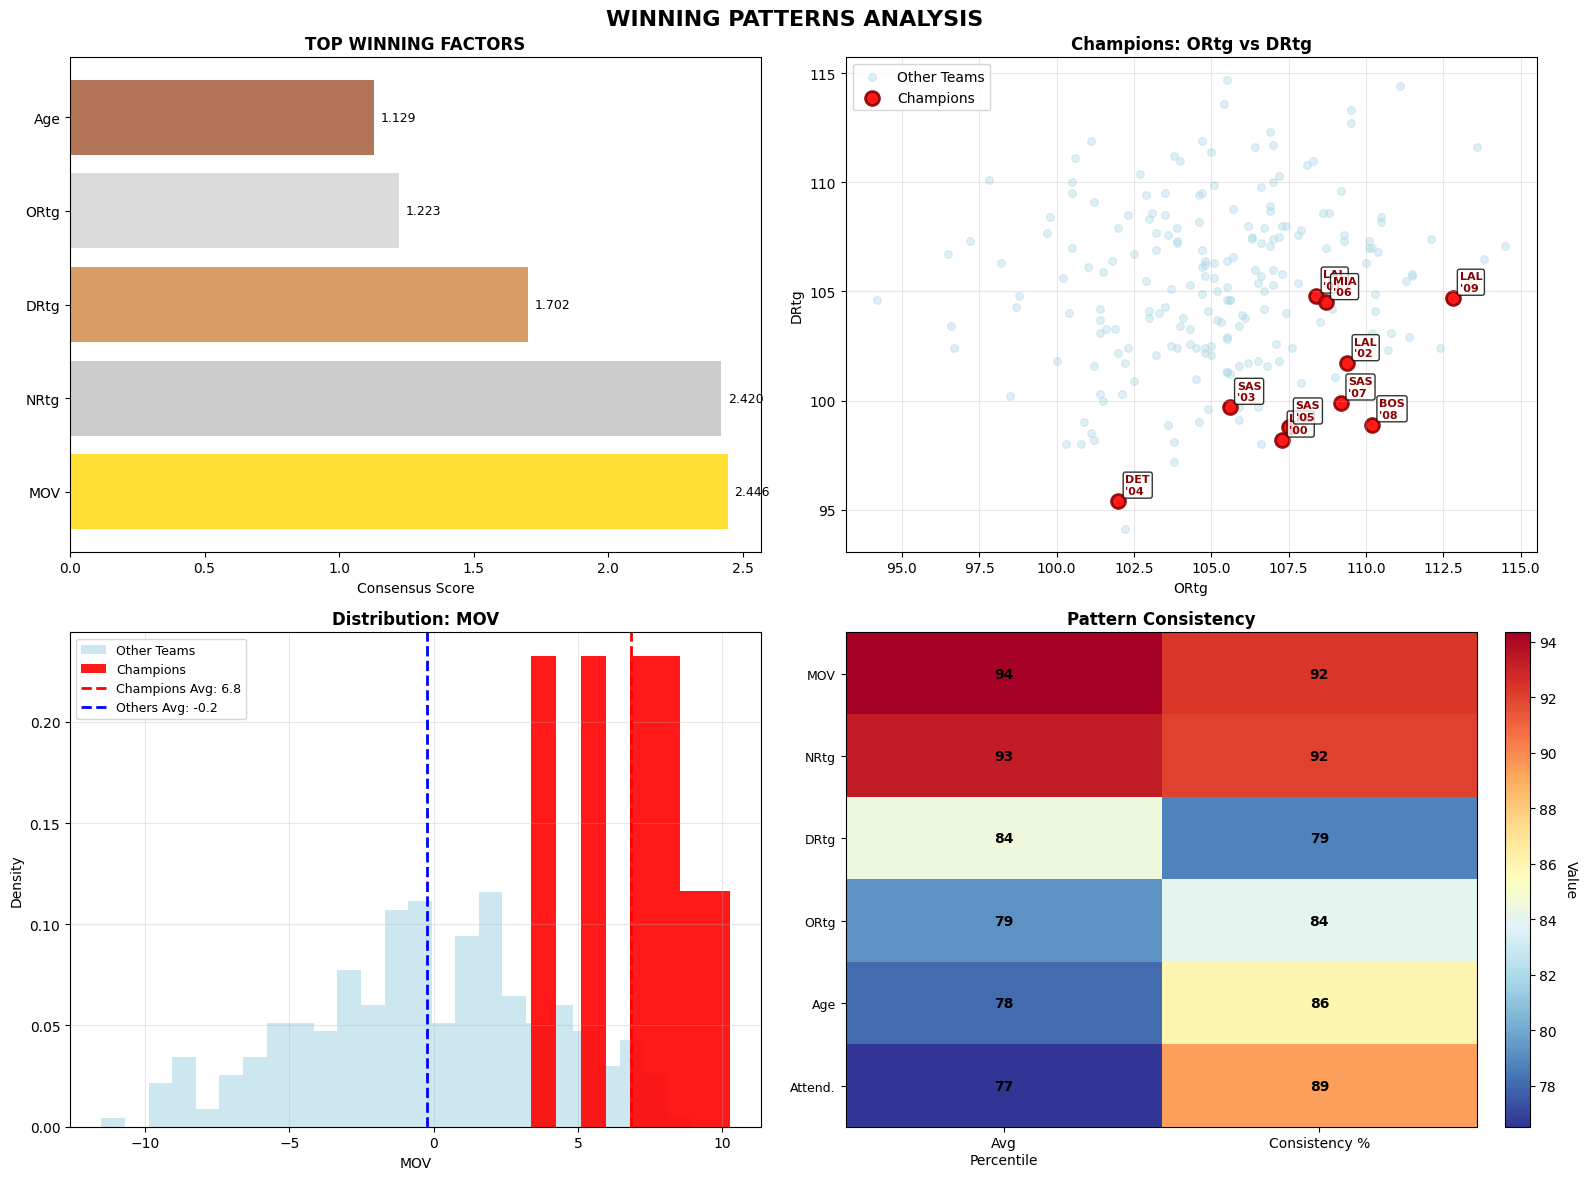

In [44]:
# 2000s
pattern = find_champs_pattern(scraping_functions_team, 2000, 2009)

Squadre totali: 300


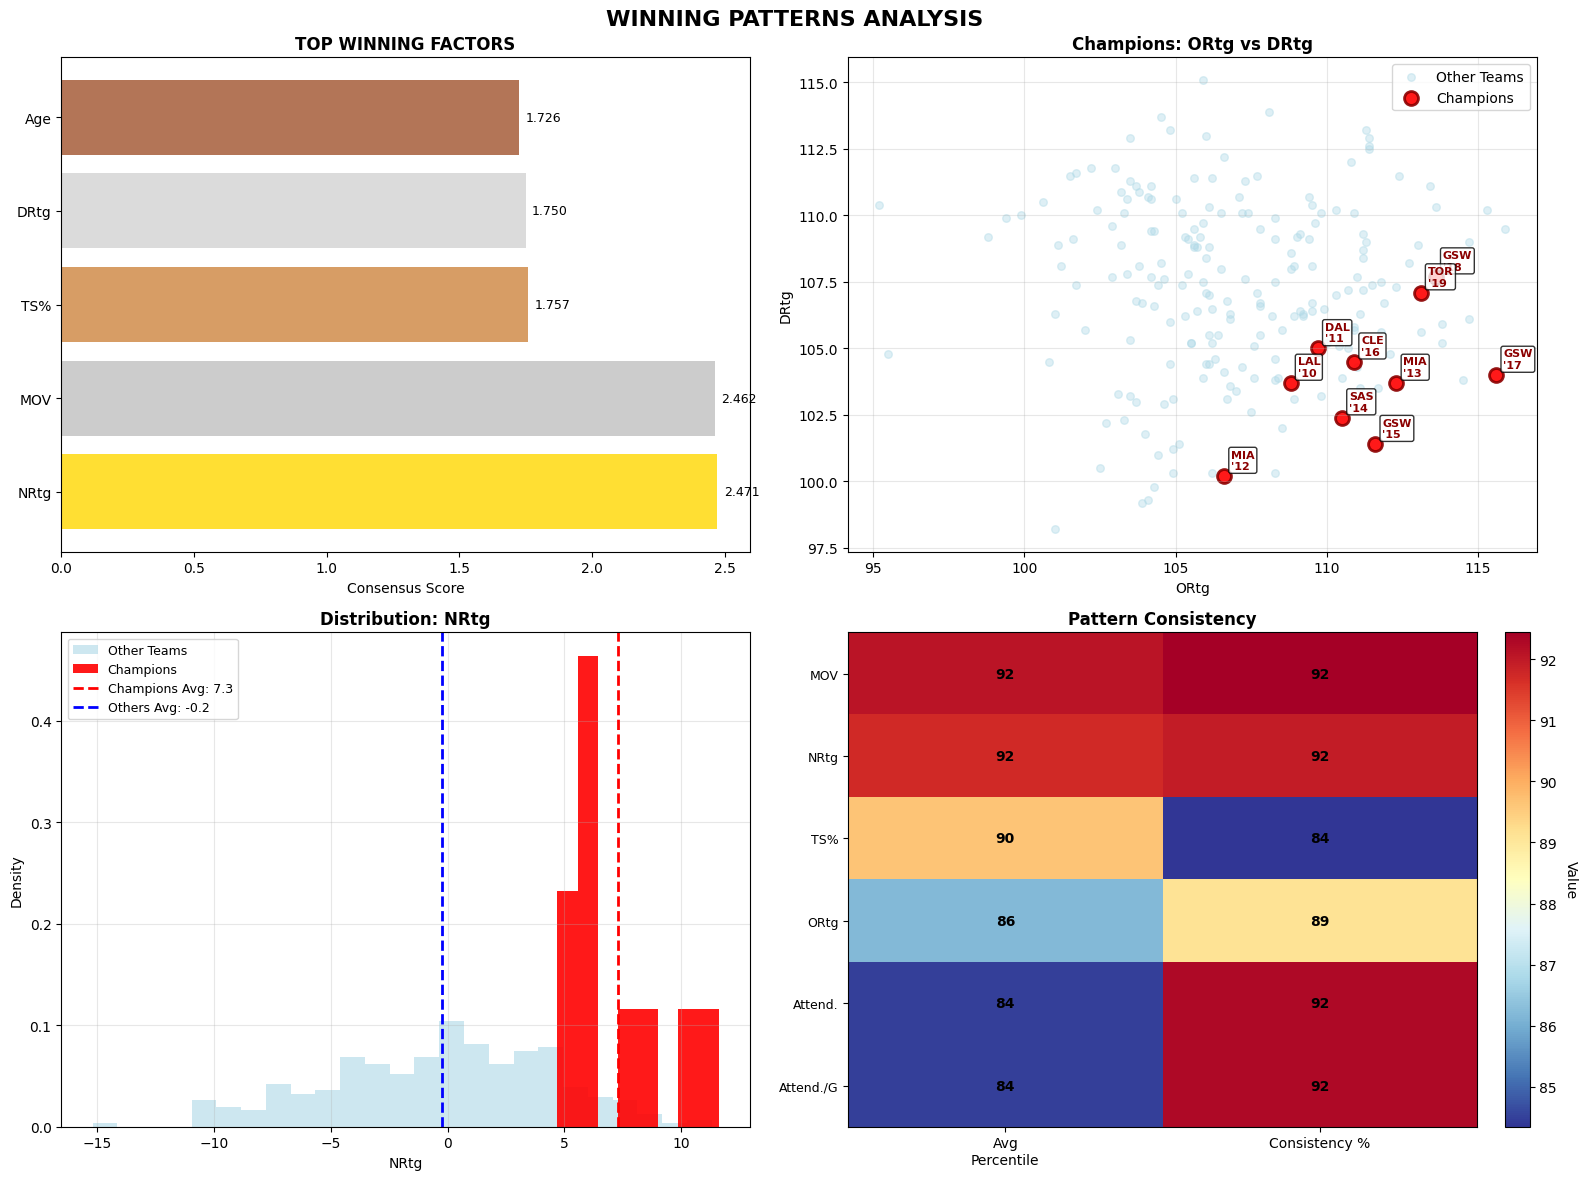

In [45]:
# 2010s
pattern = find_champs_pattern(scraping_functions_team, 2010, 2019)

Squadre totali: 180


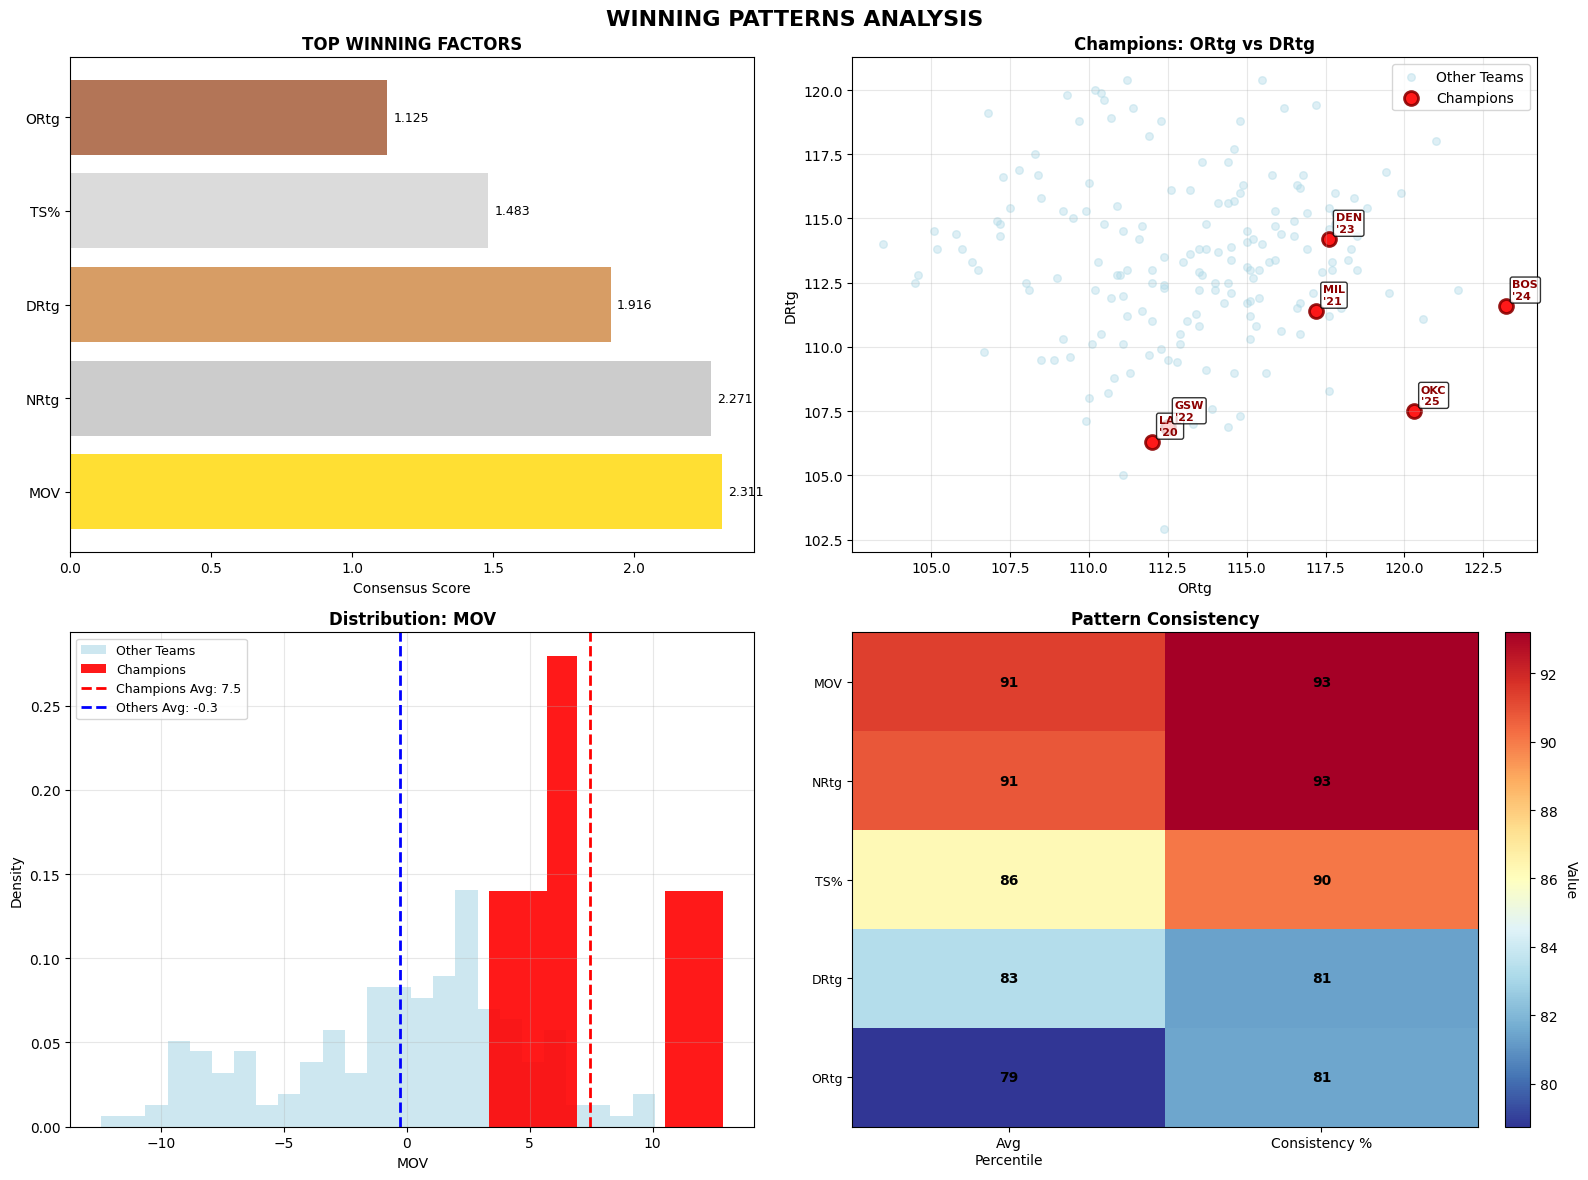

In [46]:
# 2020s
pattern = find_champs_pattern(scraping_functions_team, 2020, 2025)

### Osservazioni
- **NRtg** e **MOV** particolarmente importanti secondo i due modelli, con una media di 2,401 e 2,384
- Altra statistica importante **TS%**
- Nelle analisi del periodo 2000-2019 risulta importante anche l'**età**
- Anche la statistica **Attendance** compare più volte

Cerchiamo altre risposte...

## ROSTER ANALYSIS
Approfondiamo l'analisi studiando la composizione dei *roster* delle squadre campioni e ricercando delle differenze rispetto al resto delle squadre della lega.


CONFRONTO - MEDIE PERCENTUALI:
Archetipo                 Campioni     Lega         Differenza  
Superstar/Primary Scorer       7.4%         4.6%        +2.8%
Playmaker                      5.3%         7.6%        -2.3%
3PT Shooter                    8.7%         8.5%        +0.2%
Rim Protector                 14.9%        18.7%        -3.8%
Perimeter Defender            21.8%        22.2%        -0.4%
Stretch Big                   18.7%        17.2%        +1.5%
All-around threat              9.4%        10.2%        -0.8%
Floor General                  6.7%         6.8%        -0.1%
Veteran                        7.0%         4.1%        +2.8%


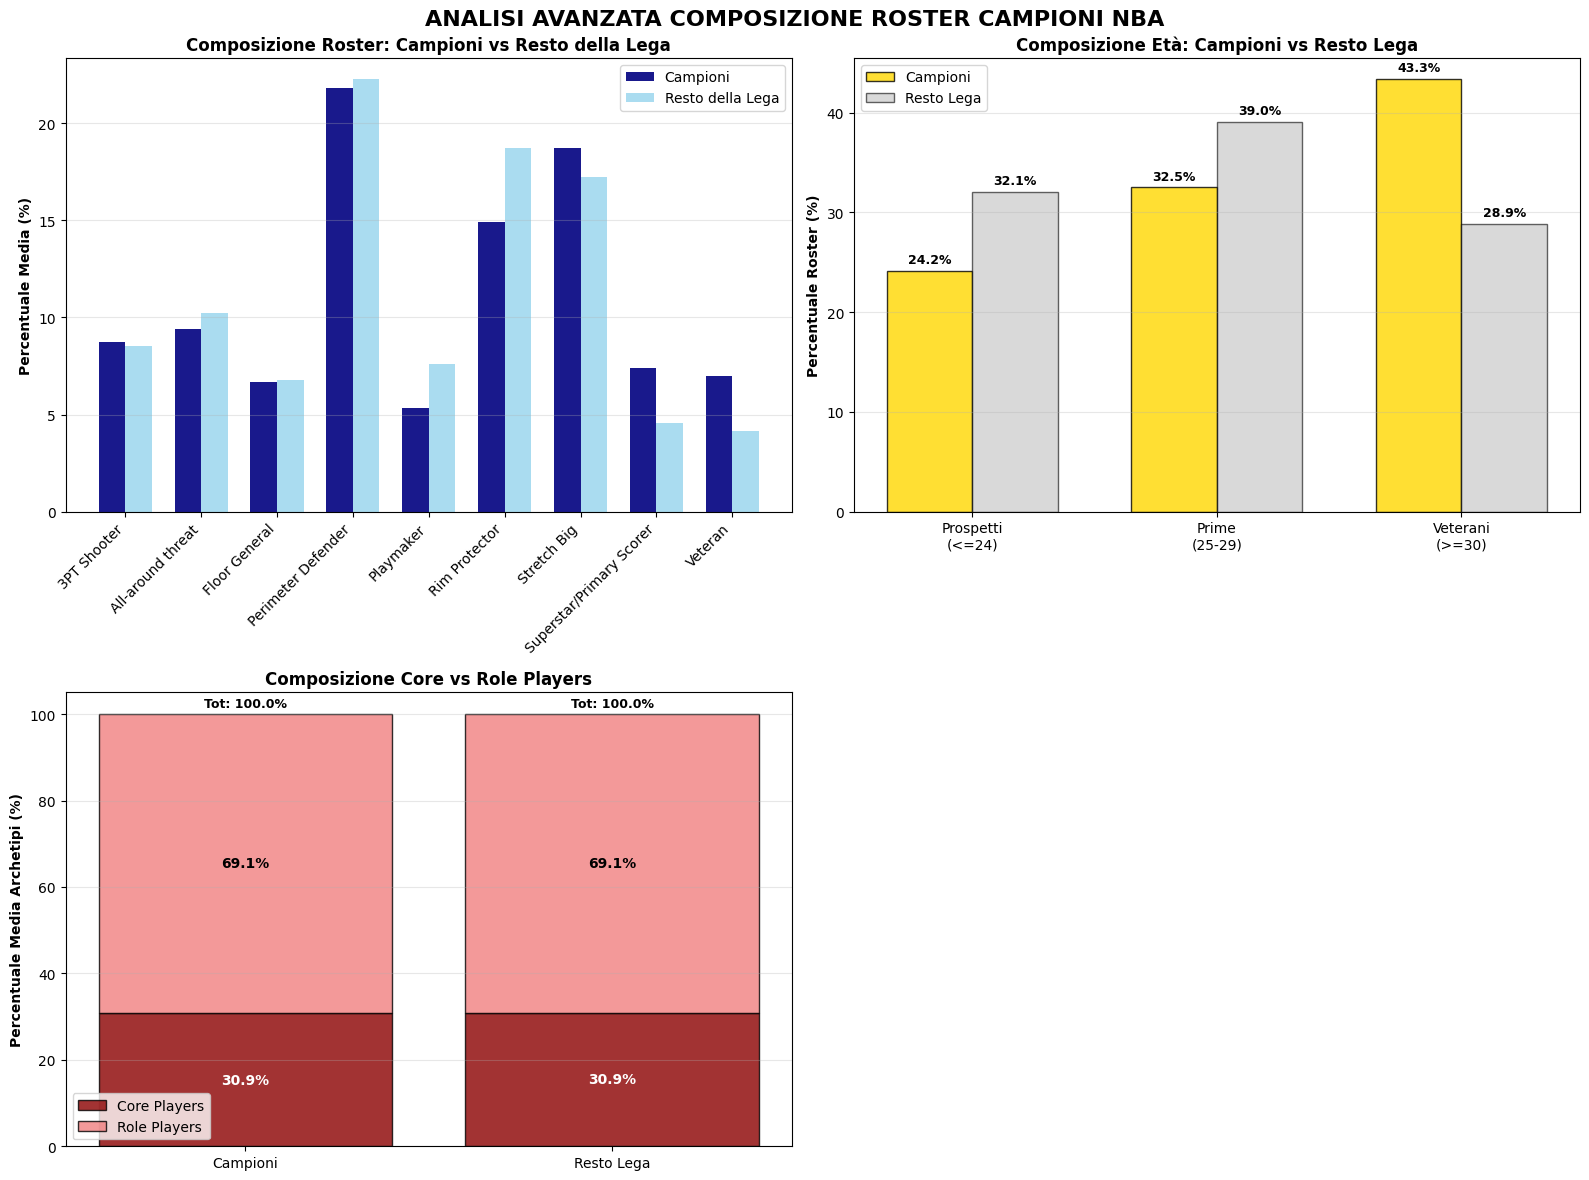

In [47]:
# 2000s
roster = analyze_champions(scraping_functions_roster, 2000, 2009)


CONFRONTO - MEDIE PERCENTUALI:
Archetipo                 Campioni     Lega         Differenza  
Superstar/Primary Scorer       9.0%         5.1%        +3.9%
Playmaker                      5.1%         6.6%        -1.5%
3PT Shooter                    9.5%        10.6%        -1.0%
Rim Protector                 14.6%        16.6%        -2.0%
Perimeter Defender            18.1%        18.4%        -0.3%
Stretch Big                   20.2%        22.9%        -2.7%
All-around threat             11.6%        10.2%        +1.4%
Floor General                  8.6%         6.8%        +1.8%
Veteran                        3.2%         2.8%        +0.4%


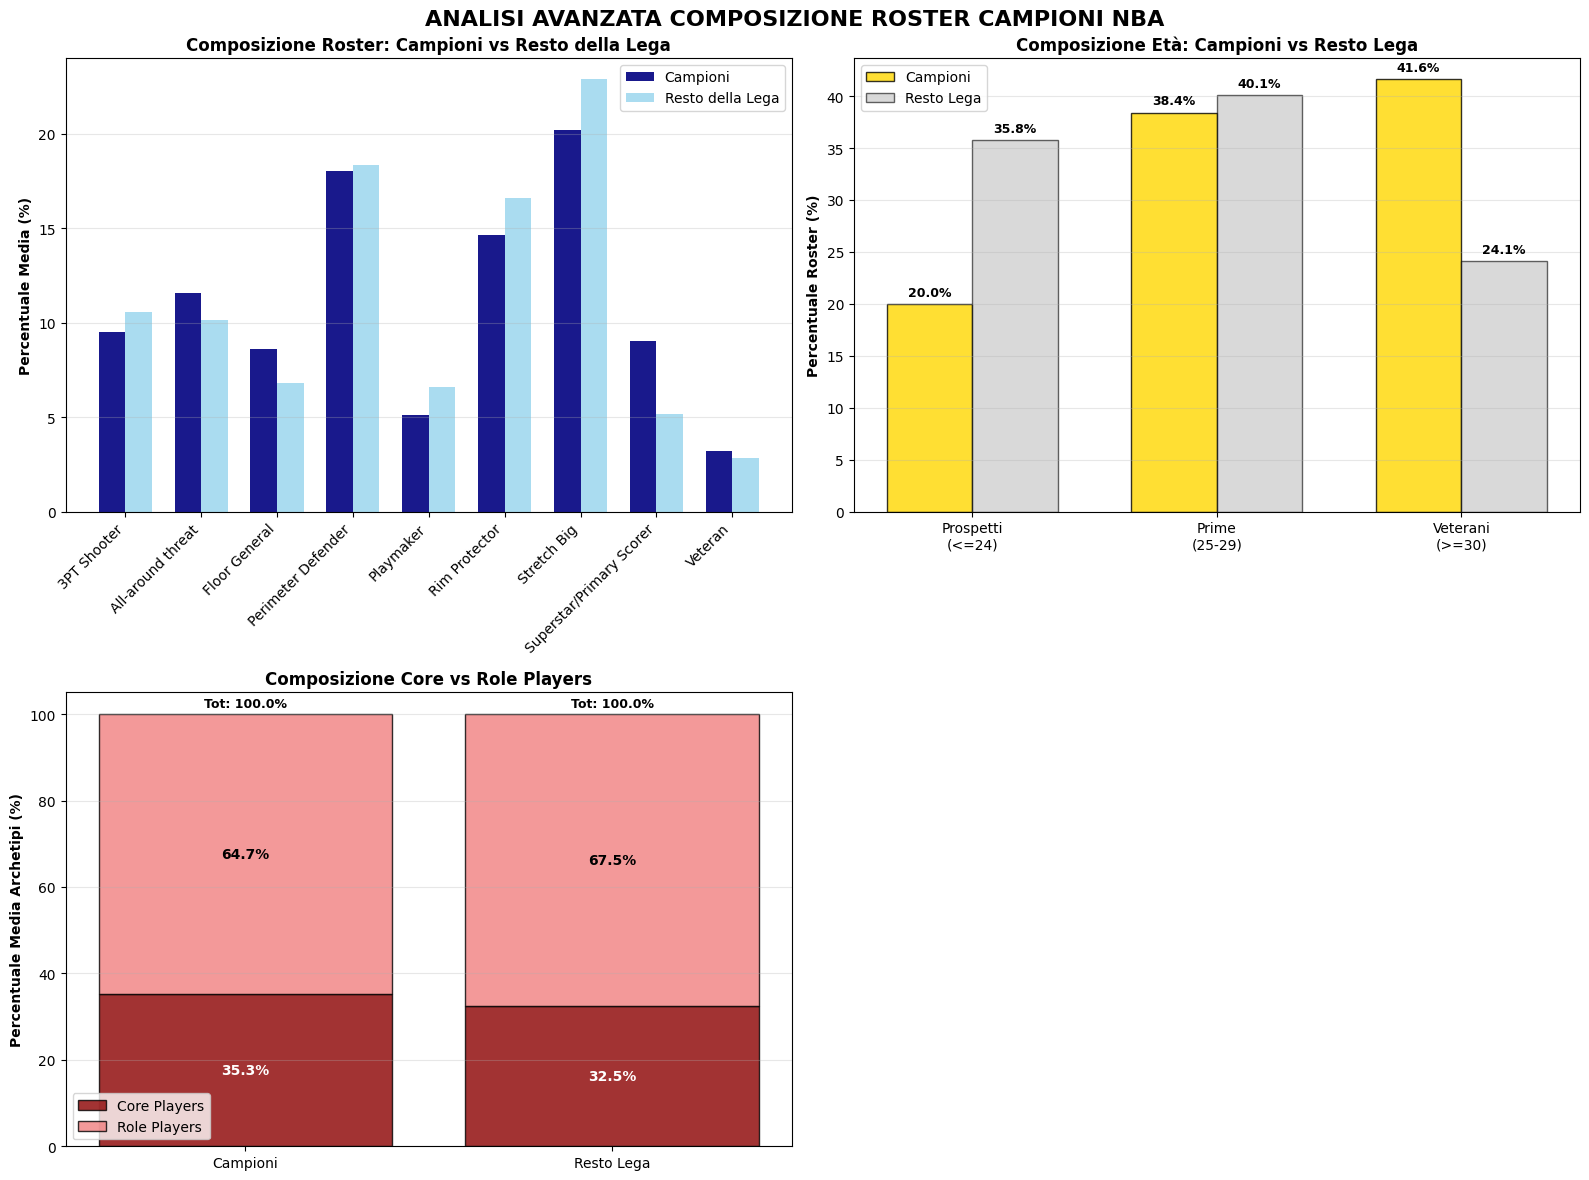

In [48]:
# 2010s
roster = analyze_champions(scraping_functions_roster, 2010, 2019)


CONFRONTO - MEDIE PERCENTUALI:
Archetipo                 Campioni     Lega         Differenza  
Superstar/Primary Scorer       8.0%         6.5%        +1.5%
Playmaker                      4.7%         5.6%        -0.9%
3PT Shooter                   12.7%        12.4%        +0.3%
Rim Protector                  9.2%        13.4%        -4.2%
Perimeter Defender            15.7%        13.8%        +1.9%
Stretch Big                   24.2%        25.5%        -1.3%
All-around threat             11.1%        10.4%        +0.7%
Floor General                 11.5%        10.5%        +1.0%
Veteran                        2.9%         2.0%        +0.9%


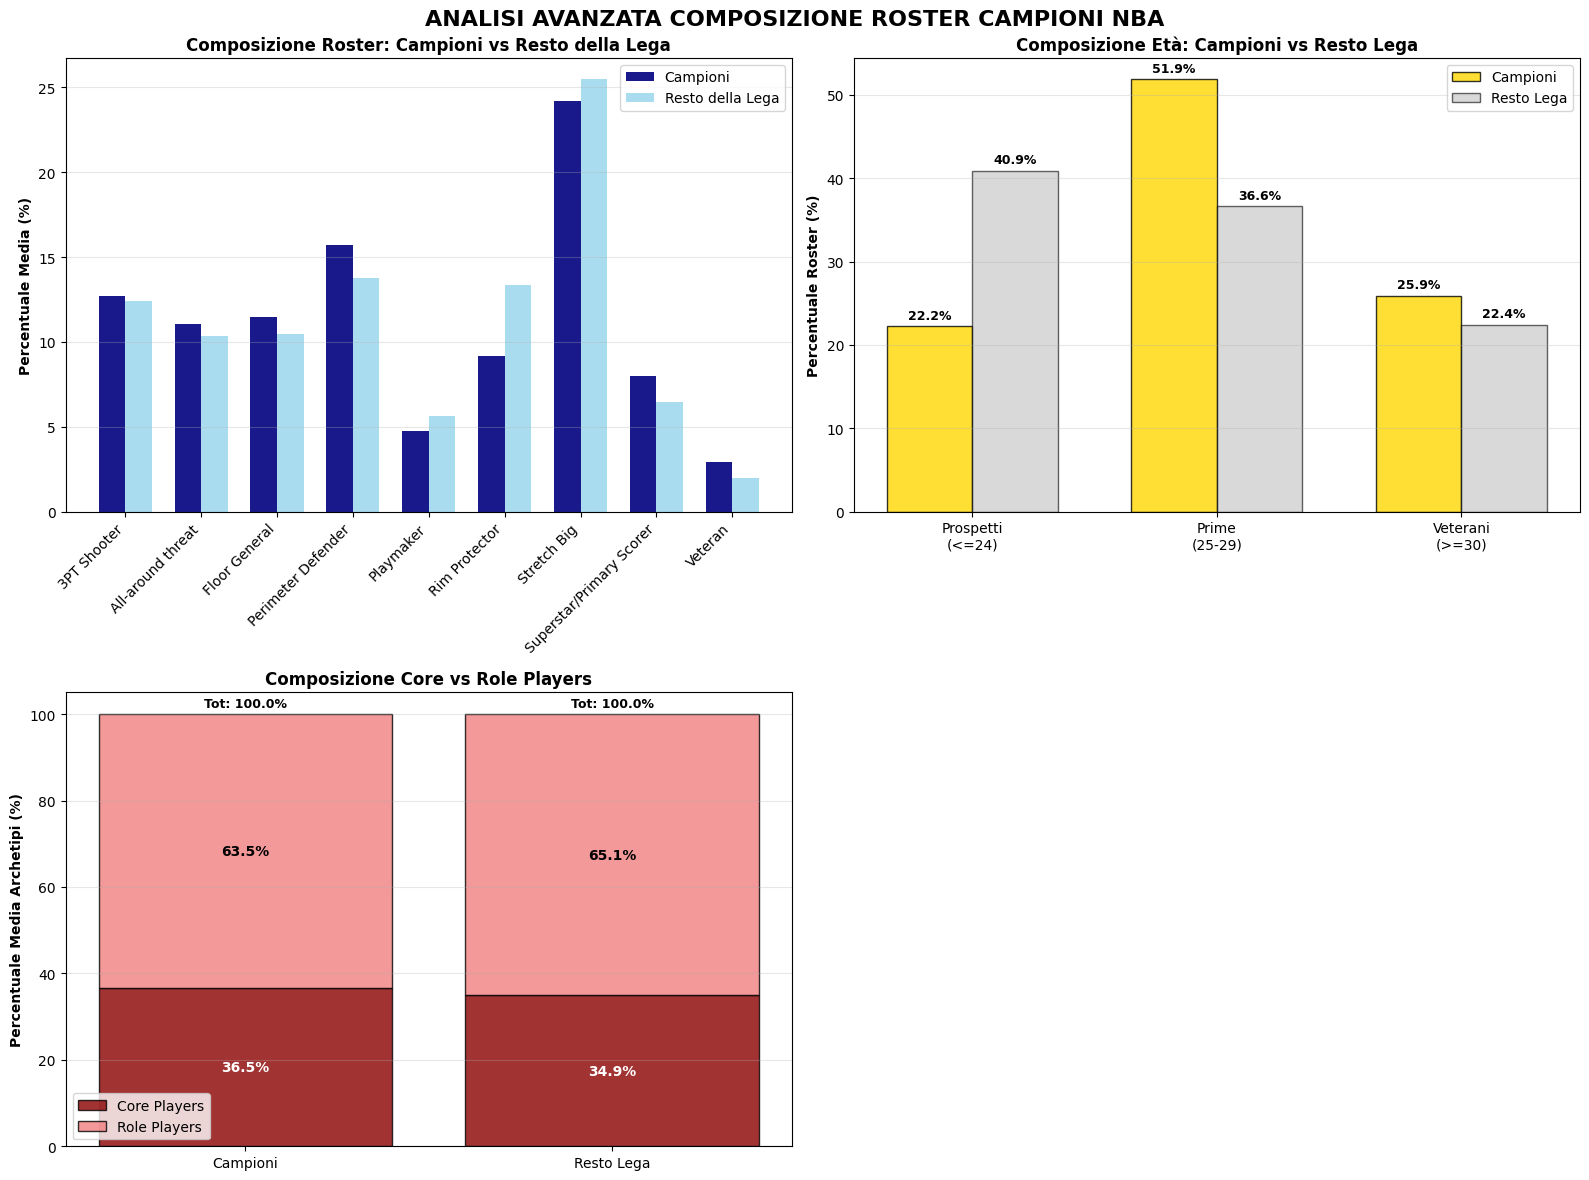

In [49]:
# 2020s
roster = analyze_champions(scraping_functions_roster, 2020, 2025)

### Osservazioni
La differenza principale è nella presenza di **superstar**, con un valore medio di +2.73%.<br>
Altre considerazioni sulle squadre che hanno vinto il titolo:
- Non è considerata importante la figura di un 'Rim Protector' (-3.34% di media)
- Recentemente, rilevanti i giocatori di tipo 'Perimeter Defender' (+1.9%)

Analisi dell'**età**:
- Nel periodo 2000-2019 le squadre **campioni** avevano +15.95% di veterani in media (a discapito dei giovani)
- Nelle ultime **sei** stagioni, i roster vincenti sono composti da pochi *giovani*, pochi *veterani* (ma +3.5% della *media della lega*) e la maggioranza del roster (**51.9%**) è composto da giocatori nel loro **prime** agonistico

## PLAYOFF ANALYSIS
Infine, valutiamo le differenze tra i campioni e le altre squadre che hanno partecipato ai *Playoff*.<br>Quali elementi hanno permesso loro di ottenere l'anello?

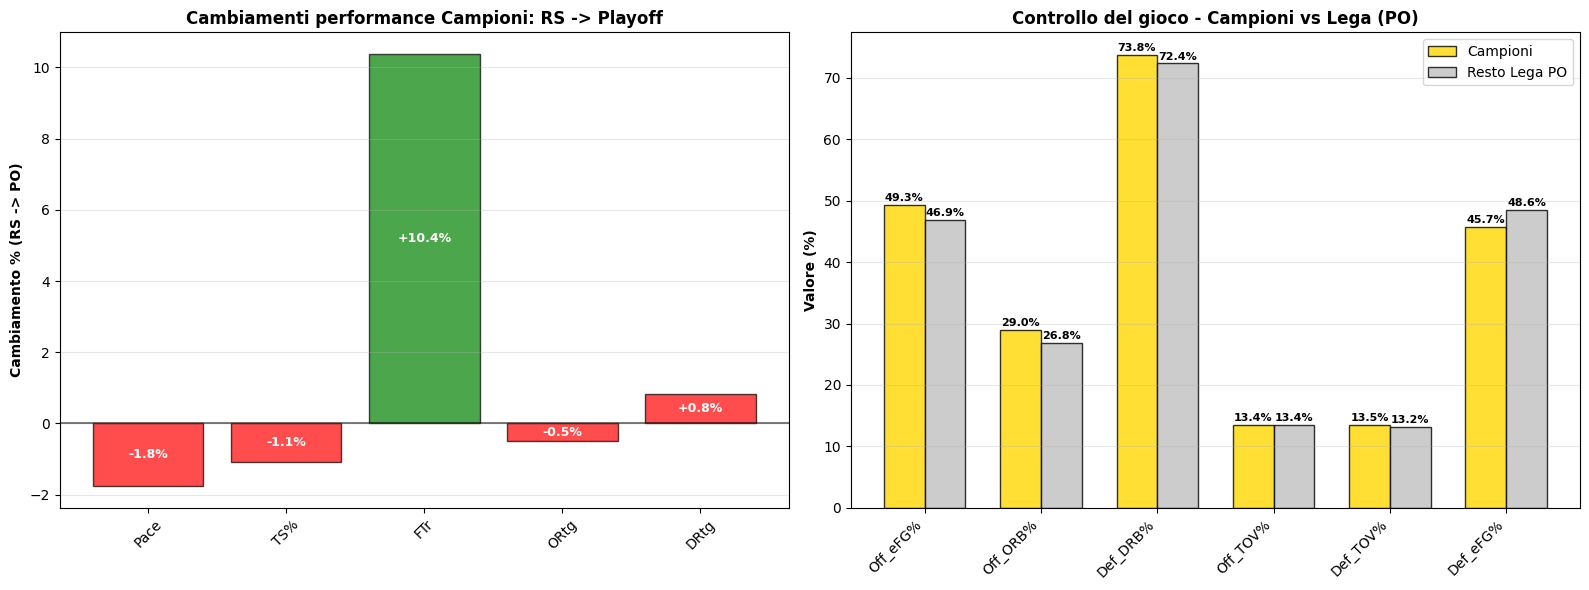


CAMPIONI vs LEGA - PLAYOFF:
(Le percentuali indicano la differenza relativa tra la media dei campioni
e la media del resto della lega nei playoff)

Statistica         | Campioni     | Lega         | Differenza          
----------------------------------------------------------------------
NRtg               | 6.1          | -3.4         | +9.56 punti 
Off_ORB%           | 29.0         | 26.8         | +2.21 punti (+8.2%) 
Def_eFG%           | 45.7%        | 48.6%        | -0.03 punti (-5.9%) 
Off_eFG%           | 49.3%        | 46.9%        | +0.02 punti (+5.0%) 
TS%                | 53.6%        | 51.8%        | +0.02 punti (+3.4%) 
Def_DRB%           | 73.8         | 72.4         | +1.37 punti (+1.9%) 
Def_TOV%           | 13.5         | 13.2         | +0.25 punti (+1.9%) 
Pace               | 89.4         | 89.2         | +0.23 punti (+0.3%) 
Off_TOV%           | 13.4         | 13.4         | -0.02 punti (-0.2%) 


In [50]:
# 2000s
playoff = analyze_playoff_performance(scraping_functions_PO, 2000,2009)

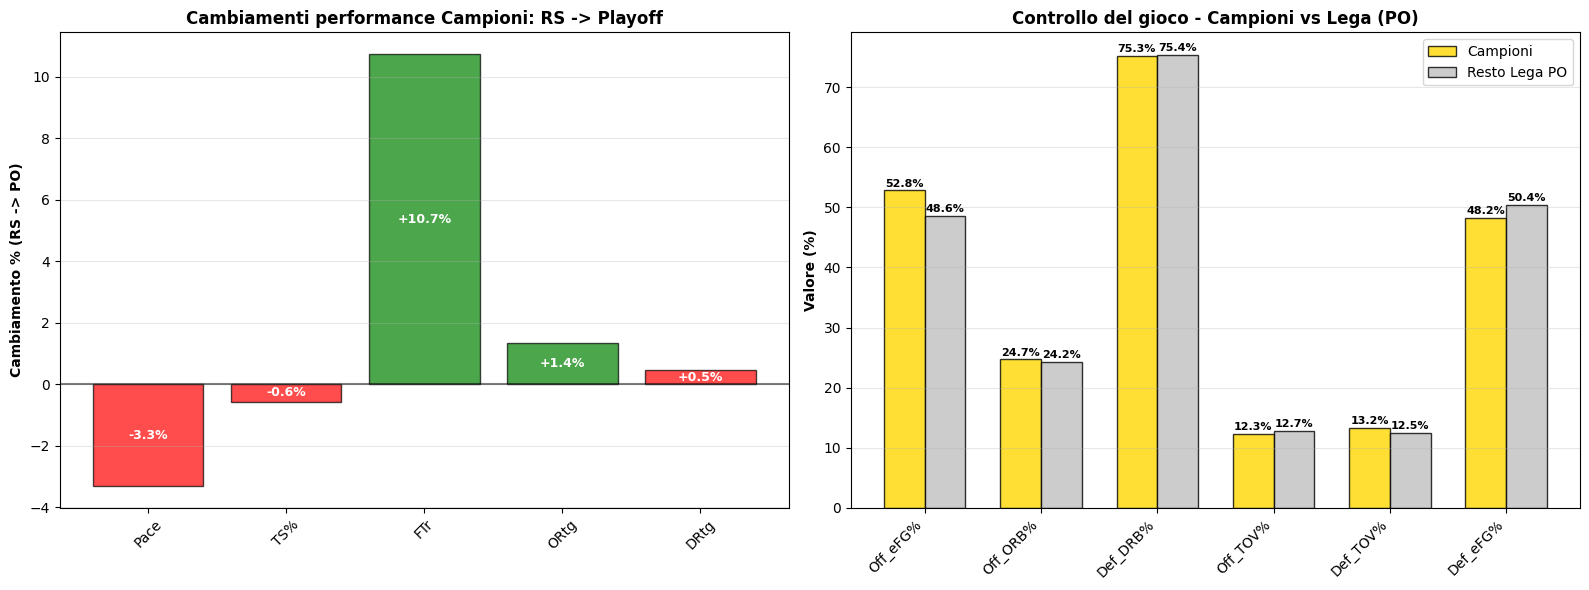


CAMPIONI vs LEGA - PLAYOFF:
(Le percentuali indicano la differenza relativa tra la media dei campioni
e la media del resto della lega nei playoff)

Statistica         | Campioni     | Lega         | Differenza          
----------------------------------------------------------------------
NRtg               | 8.3          | -3.5         | +11.81 punti 
Off_eFG%           | 52.8%        | 48.6%        | +0.04 punti (+8.6%) 
TS%                | 56.8%        | 52.9%        | +0.04 punti (+7.4%) 
Def_TOV%           | 13.2         | 12.5         | +0.74 punti (+5.9%) 
Def_eFG%           | 48.2%        | 50.4%        | -0.02 punti (-4.4%) 
Off_TOV%           | 12.3         | 12.7         | -0.40 punti (-3.1%) 
Off_ORB%           | 24.7         | 24.2         | +0.46 punti (+1.9%) 
Pace               | 92.1         | 92.3         | -0.22 punti (-0.2%) 
Def_DRB%           | 75.3         | 75.4         | -0.12 punti (-0.2%) 


In [51]:
# 2010s
playoff = analyze_playoff_performance(scraping_functions_PO, 2010,2019)

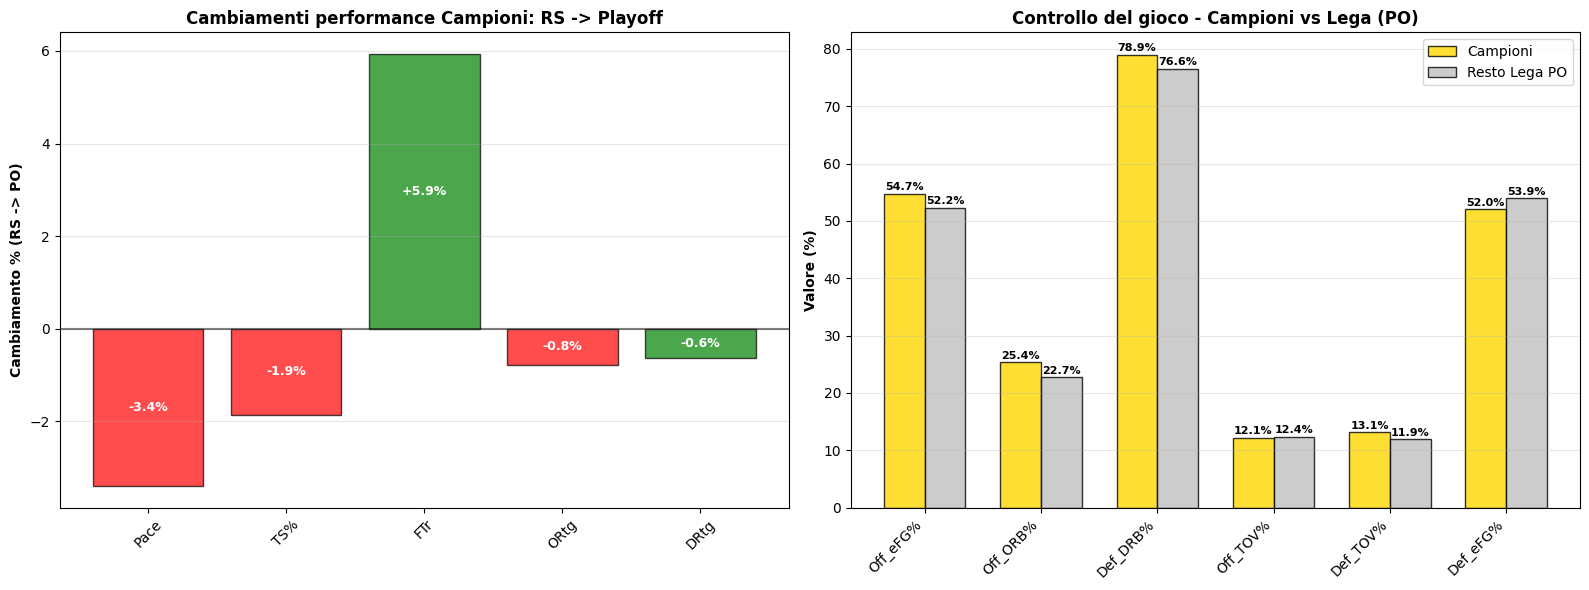


CAMPIONI vs LEGA - PLAYOFF:
(Le percentuali indicano la differenza relativa tra la media dei campioni
e la media del resto della lega nei playoff)

Statistica         | Campioni     | Lega         | Differenza          
----------------------------------------------------------------------
NRtg               | 7.2          | -3.8         | +11.01 punti 
Off_ORB%           | 25.4         | 22.7         | +2.64 punti (+11.6%) 
Def_TOV%           | 13.1         | 11.9         | +1.22 punti (+10.3%) 
Off_eFG%           | 54.7%        | 52.2%        | +0.02 punti (+4.7%) 
Def_eFG%           | 52.0%        | 53.9%        | -0.02 punti (-3.6%) 
TS%                | 58.0%        | 56.1%        | +0.02 punti (+3.5%) 
Def_DRB%           | 78.9         | 76.6         | +2.37 punti (+3.1%) 
Off_TOV%           | 12.1         | 12.4         | -0.26 punti (-2.1%) 
Pace               | 96.1         | 95.7         | +0.36 punti (+0.4%) 


In [52]:
# 2020s
playoff = analyze_playoff_performance(scraping_functions_PO, 2020,2025)

### Osservazioni
Differenze tra le statistiche dei campioni durante la *RS* e durante i *PO*:
- **NRtg** (+10.79 punti in media)
- **Pace** si abbassa (-2.83% in media)
- **FTr** (+9% in media)

Nei *PO*, differenza tra la media dei campioni e la media del resto della lega:
- **Controllo** del gioco: ORB% (+7.23%), DRB% (+1.7%), Off_TOV% (-1.73%)
- **Difesa**: Def_eFG% (-4.63%), Def_TOV% (+6.03%)
- **Efficienza**: TS% (+4.76%), Off_eFG% (+6.1%)

# Conclusioni
Quali elementi comuni condividono le squadre che sono riuscite a vincere il titolo?<br>
L'analisi condotta sui dati delle stagioni NBA dal 2000 al 2025 rivela che il successo si basa su una combinazione di *efficienza offensiva*, *costanza difensiva* e una matura *composizione del roster*.
- Alto **MOV** e **NRtg** (alto **ORtg** e basso **DRtg**). Dominio su entrambi i lati del campo
- **Efficienza** totale al tiro, dal campo e dalla lunetta
- Roster versatile con **esperienza** e **star power**
- **Winning DNA**: capacità di controllare il gioco e rimanere lucidi (specialmente ai *PO*)
- Controllo dei **rimbalzi**
- **Difesa** che spinge a fare errori e prendere tiri contrastati/affrettati